In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pycountry
import pandas as pd
import zipfile
import math

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD

from sklearn.linear_model import LinearRegression

In [4]:
# Importing data
main_df = pd.read_excel("Data/organizedviolencecy_v23_2.xlsx")

# List of country codes to keep (recognized country)
recognized_country_codes = [
    "AFG", "ALA", "ALB", "DZA", "ASM", "AND", "AGO", "AIA", "ATA", "ATG", "ARG", "ARM", "ABW", "AUS", "AUT", "AZE",
    "BHS", "BHR", "BGD", "BRB", "BLR", "BEL", "BLZ", "BEN", "BMU", "BTN", "BOL", "BES", "BIH", "BWA", "BVT", "BRA",
    "IOT", "BRN", "BGR", "BFA", "BDI", "CPV", "KHM", "CMR", "CAN", "CYM", "CAF", "TCD", "CHL", "CHN", "CXR", "CCK",
    "COL", "COM", "COG", "COD", "COK", "CRI", "CIV", "HRV", "CUB", "CUW", "CYP", "CZE", "DNK", "DJI", "DMA", "DOM",
    "ECU", "EGY", "SLV", "GNQ", "ERI", "EST", "SWZ", "ETH", "FLK", "FRO", "FJI", "FIN", "FRA", "GUF", "PYF", "ATF",
    "GAB", "GMB", "GEO", "DEU", "GHA", "GIB", "GRC", "GRL", "GRD", "GLP", "GUM", "GTM", "GGY", "GIN", "GNB", "GUY",
    "HTI", "HMD", "VAT", "HND", "HKG", "HUN", "ISL", "IND", "IDN", "IRN", "IRQ", "IRL", "IMN", "ISR", "ITA", "JAM",
    "JPN", "JEY", "JOR", "KAZ", "KEN", "KIR", "PRK", "KOR", "KWT", "KGZ", "LAO", "LVA", "LBN", "LSO", "LBR", "LBY",
    "LIE", "LTU", "LUX", "MAC", "MDG", "MWI", "MYS", "MDV", "MLI", "MLT", "MHL", "MTQ", "MRT", "MUS", "MYT", "MEX",
    "FSM", "MDA", "MCO", "MNG", "MNE", "MSR", "MAR", "MOZ", "MMR", "NAM", "NRU", "NPL", "NLD", "NCL", "NZL", "NIC",
    "NER", "NGA", "NIU", "NFK", "MKD", "MNP", "NOR", "OMN", "PAK", "PLW", "PSE", "PAN", "PNG", "PRY", "PER", "PHL",
    "PCN", "POL", "PRT", "PRI", "QAT", "REU", "ROU", "RUS", "RWA", "BLM", "SHN", "KNA", "LCA", "MAF", "SPM", "VCT",
    "WSM", "SMR", "STP", "SAU", "SEN", "SRB", "SYC", "SLE", "SGP", "SXM", "SVK", "SVN", "SLB", "SOM", "ZAF", "SGS",
    "SSD", "ESP", "LKA", "SDN", "SUR", "SJM", "SWE", "CHE", "SYR", "TWN", "TJK", "TZA", "THA", "TLS", "TGO", "TKL",
    "TON", "TTO", "TUN", "TUR", "TKM", "TCA", "TUV", "UGA", "UKR", "ARE", "GBR", "USA", "UMI", "URY", "UZB", "VUT",
    "VEN", "VNM", "VGB", "VIR", "WLF", "ESH", "YEM", "ZMB", "ZWE"
]


In [5]:


# Create dictionaries to map country names to ISO codes and vice versa
country_name_to_iso = {country.name: country.alpha_3 for country in pycountry.countries}
iso_to_country_name = {country.alpha_3: country.name for country in pycountry.countries}

# Create DataFrames from the dictionaries
df_country_name_to_iso = pd.DataFrame(list(country_name_to_iso.items()), columns=['Country Name', 'ISO_Code'])
df_iso_to_country_name = pd.DataFrame(list(iso_to_country_name.items()), columns=['ISO_Code', 'Country Name'])

# Merge the DataFrames into a single DataFrame without duplicating "Country Name"
iso_df = pd.merge(df_country_name_to_iso, df_iso_to_country_name, on='ISO_Code', how='inner', suffixes=('_country', '_iso'))

# Rename the "Country Name" column to "Name"
iso_df.rename(columns={'Country Name_country': 'Name', 'ISO_Code': 'stateid'}, inplace=True)

# Drop the duplicate "Country Name_iso" column
iso_df.drop(columns=['Country Name_iso'], inplace=True)

# Only keep the countries in the recognized_country_codes list
iso_df = iso_df[iso_df['stateid'].isin(recognized_country_codes)]



In [6]:
# Cleaning of GDP dataset: GDP between 1989 and 2022 in current US dollars
gdp_df = pd.read_csv("Data/gdp_world.csv", skiprows=4)



# Only keep relevant columns
gdp_df = gdp_df[["Country Name", "Country Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997",
                 "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010",
                 "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"]]

# Only keep the countries recognized in the recognized_country_codes list
gdp_df = gdp_df[gdp_df["Country Code"].isin(recognized_country_codes)]

# Backfill NaN values
gdp_df = gdp_df.fillna(method='bfill', axis=1)

# rename Country Code to stateid
gdp_df = gdp_df.rename(columns={"Country Code": "stateid"})

# Frontfill NaN values -> some countries miss their 2022 value
gdp_df = gdp_df.fillna(method='ffill', axis=1)

# Replace country name next to stateid = COD to "DR Congo (Zaire)"
gdp_df.loc[gdp_df['stateid'] == 'COD', 'Country Name'] = "DR Congo (Zaire)"

# Initialize the mapping dictionary
name_mapping = {
    "Congo, Dem. Rep.": "Congo",
    "Tanzania": "Tanzania, United Republic of",
    "Turkiye": "Türkiye",
    "Moldova": "Moldova, Republic of",
    "Bahamas, The": "Bahamas",
    "Macao SAR, China": "China",
    "Korea, Rep.": "Korea, Republic of",
    "Curacao": "Curaçao",
    "Egypt, Arab Rep.": "Egypt",
    "Congo, Rep.": "Congo",
    "Bolivia": "Bolivia, Plurinational State of",
    "Virgin Islands (U.S.)": "Virgin Islands, U.S.",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Martin (French part)": "Saint Martin (French part)",
    "Hong Kong SAR, China": "Hong Kong",
    "British Virgin Islands": "Virgin Islands, British",
    "Yemen, Rep.": "Yemen",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "Gambia, The": "Gambia",
}

# Manually update the mapping dictionary with the correct ISO names
name_mapping["Micronesia, Fed. Sts."] = "Micronesia, Federated States of"
name_mapping["Lao PDR"] = "Laos"
name_mapping["Iran, Islamic Rep."] = "Iran, Islamic Republic of"
name_mapping["Korea, Dem. People's Rep."] = "Korea, Democratic People's Republic of"
name_mapping["Kyrgyz Republic"] = "Kyrgyzstan"
name_mapping["St. Lucia"] = "Saint Lucia"
name_mapping["Slovak Republic"] = "Slovakia"

# Apply name mapping to GDP dataset
gdp_df['Country Name'] = gdp_df['Country Name'].map(name_mapping).fillna(gdp_df['Country Name'])

gdp_countries = gdp_df['Country Name'].unique()
iso_countries = iso_df['Name'].unique()

# Check if the same stateid is used for each country in both datasets
consistent_stateids = True
inconsistent_countries = []

for country in gdp_countries:
    if country in iso_countries:
        gdp_stateid = gdp_df.loc[gdp_df['Country Name'] == country, 'stateid'].iloc[0]
        iso_stateid = iso_df.loc[iso_df['Name'] == country, 'stateid'].iloc[0]
        
        if gdp_stateid != iso_stateid:
            consistent_stateids = False
            inconsistent_countries.append(country)

if consistent_stateids:
    print("The same stateid is used for each country in both datasets.")
else:
    print("The stateids are not consistent for the following countries:")
    print(inconsistent_countries)

# No data available for North Korea; estimation from tradingeconomics.com + linear interpolation

nk_gdp = {
    1989: 15770000000,
    1990: None,
    1991: None,
    1992: 11000000000,
    1993: None,
    1994: None,
    1995: 4850000000,
    1996: None,
    1997: None,
    1998: 11000000000,
    1999: None,
    2000: None,
    2001: None,
    2002: None,
    2003: None,
    2004: None,
    2005: None,
    2006: None,
    2007: None,
    2008: None,
    2009: None,
    2010: None,
    2011: None,
    2012: None,
    2013: None,
    2014: None,
    2015: None,
    2016: None,
    2017: None,
    2018: None,
    2019: None,
    2020: None,
    2021: None,
    2022: 20000000000
}

# Convert the dictionary to a DataFrame
nk_gdp_df = pd.DataFrame.from_dict(nk_gdp, orient='index', columns=['GDP'])

# Convert index to a column
nk_gdp_df.reset_index(inplace=True)
nk_gdp_df.rename(columns={'index': 'Year'}, inplace=True)

# Interpolate missing values linearly
nk_gdp_df['GDP'] = nk_gdp_df['GDP'].interpolate()

# Provided data
nk_gdp_values = {
    1989: 1.577000e+10, 1990: 1.418000e+10, 1991: 1.259000e+10, 1992: 1.100000e+10, 1993: 8.950000e+09,
    1994: 6.900000e+09, 1995: 4.850000e+09, 1996: 6.900000e+09, 1997: 8.950000e+09, 1998: 1.100000e+10,
    1999: 1.137500e+10, 2000: 1.175000e+10, 2001: 1.212500e+10, 2002: 1.250000e+10, 2003: 1.287500e+10,
    2004: 1.325000e+10, 2005: 1.362500e+10, 2006: 1.400000e+10, 2007: 1.437500e+10, 2008: 1.475000e+10,
    2009: 1.512500e+10, 2010: 1.550000e+10, 2011: 1.587500e+10, 2012: 1.625000e+10, 2013: 1.662500e+10,
    2014: 1.700000e+10, 2015: 1.737500e+10, 2016: 1.775000e+10, 2017: 1.812500e+10, 2018: 1.850000e+10,
    2019: 1.887500e+10, 2020: 1.925000e+10, 2021: 1.962500e+10, 2022: 2.000000e+10
}

# Locate the row with stateid equal to "PRK" in gdp_df
prk_row_index = gdp_df.index[gdp_df['stateid'] == 'PRK'].tolist()[0]

# Replace the values in columns 1989 to 2022 with the provided values
for year, gdp_value in nk_gdp_values.items():
    gdp_df.at[prk_row_index, str(year)] = gdp_value


# No data for Virgin Islands and Gibraltar: drop the columns (not used in main_df)
gdp_df = gdp_df[~gdp_df['stateid'].isin(['VGB', 'GIB'])]


The same stateid is used for each country in both datasets.


C:\Users\troen\AppData\Local\Temp\ipykernel_28216\4244091700.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='bfill', axis=1)
C:\Users\troen\AppData\Local\Temp\ipykernel_28216\4244091700.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='ffill', axis=1)


In [7]:
# Extracting from zip file
zip_file_path = "Data/EdStats_CSV.zip"

csv_file_name = 'EdStatsData.csv'

# Open the .zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file from the .zip archive
    with zip_ref.open(csv_file_name) as csv_file:
        # Read the CSV file using pandas
        education_df = pd.read_csv(csv_file)



# Only keep relevant columns, between 1989 and 2022
education_df = education_df[["Country Name", "Country Code", "Indicator Name" ,"Indicator Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995",
                             "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006",
                             "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]

# Delete rows where every year is NaN
education_df = education_df.dropna(how='all', subset=["1989", "1990", "1991", "1992", "1993", "1994", "1995",
                                                      "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003",
                                                      "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011",
                                                      "2012", "2013", "2014", "2015", "2016", "2017"])


# Drop all rows where indicator name = Population growth (annual %)
education_df = education_df[education_df["Indicator Name"] != "Population growth (annual %)"]


# Drop all columns where more than 35% of the values are NaN
education_df = education_df.dropna(thresh=0.35*len(education_df), axis=1)

# Drop 2003, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2015
education_df = education_df.drop(columns=["2003", "2006", "2007", "2008", "2009", "2011", "2012", "2013", "2015"])

# Drop rows where the value for 1995, 2000, 2005 and 2010 is NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], how='all')

# Drop the rows where 2 or more value for 1995, 2000, 2005 and 2010 are NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], thresh=2)

# Pivot the dataframe
education_df = education_df.pivot_table(index=['Country Name', 'Country Code'], columns='Indicator Name', values=['1995', '2000', '2005', '2010'])

# Reset index to make 'Country Name' and 'Country Code' regular columns
education_df.reset_index(inplace=True)

# Flatten column names
education_df.columns = [' '.join(col).strip() for col in education_df.columns.values]

# Drop columns where more than 50% of the values are NaN
education_df = education_df.dropna(thresh=0.5*len(education_df), axis=1)

# Drop all columns that contain the word "total"
education_df = education_df[education_df.columns.drop(list(education_df.filter(like='Total')))]


In [8]:
# Cleaning the main_df

# Remove columns with disagregated deaths. Only keep "prior" information and cumulative total deaths.
main_df = main_df.loc[:, ['country_id_cy', 'country_cy', 'year_cy', 'region_cy', 'sb_dyad_count_cy', 'sb_dyad_ids_cy',
                          'sb_intrastate_dyad_count_cy', 'sb_intrastate_main_govt_inv_incomp_cy',
                          'sb_interstate_dyad_count_cy',
                          'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'ns_dyad_ids_cy',
                          'os_dyad_count_cy', 'os_dyad_ids_cy', 'os_main_govt_inv_cy', 'os_any_govt_inv_cy',
                          'os_nsgroup_inv_cy', 'cumulative_total_deaths_parties_in_orgvio_cy',
                          'cumulative_total_deaths_civilians_in_orgvio_cy', 'cumulative_total_deaths_unknown_in_orgvio_cy',
                          'cumulative_total_deaths_in_orgvio_best_cy']]

# Importing battle_death data set, to get the dyads 

# importing battle_death dataset
battle_death_df = pd.read_csv("Data/battle_deaths.csv")


# Function to get incompatibility value from battle_death_df based on dyad_id
def get_incompatibility(dyad_ids):
    # Initialize a list to store incompatibility values for each dyad_id
    incompatibilities = []
    
    # Split the dyad_ids separated by ";"
    dyad_ids = dyad_ids.split(";")
    
    # Iterate over each dyad_id
    for dyad_id in dyad_ids:
        # Check if dyad_id is 'NO_DYAD'
        if dyad_id != 'NO_DYAD':
            # Look up the incompatibility value from battle_death_df
            incompatibility = battle_death_df.loc[battle_death_df['dyad_id'] == int(dyad_id), 'incompatibility'].values
            # If the dyad_id is found, append the incompatibility value to the list
            if len(incompatibility) > 0:
                incompatibilities.extend(incompatibility)
    
    # Return the maximum incompatibility value found for the dyad_ids
    return max(incompatibilities) if incompatibilities else None

# Create a new column 'incompatibility' in main_df using the function
main_df['incompatibility'] = main_df['sb_dyad_ids_cy'].apply(get_incompatibility)

main_df.insert(main_df.columns.get_loc('sb_dyad_ids_cy') + 1, 'incompatibility', main_df.pop('incompatibility'))

# Replace NaN values from 'incompatibility' column with 0 (= no state incompatibility)
main_df['incompatibility'] = main_df['incompatibility'].fillna(0)

# Change Incompatibility values to integers
main_df['incompatibility'] = main_df['incompatibility'].astype(int)

#####################################################
non_state = pd.read_csv("Data/Nonstate_v23_1.csv")

# Convert 'dyad_id' column in 'non_state' DataFrame to string type
non_state['dyad_id'] = non_state['dyad_id'].astype(str)

# Explode the 'ns_dyad_ids_cy' column to create multiple rows for each id
exploded_df = main_df.explode('ns_dyad_ids_cy')

# Merge with 'non_state' DataFrame on 'dyad_id'
prepcluster_df = exploded_df.merge(non_state, how='left', left_on='ns_dyad_ids_cy', right_on='dyad_id')

# Convert 'org' column to string type
prepcluster_df['org'] = prepcluster_df['org'].astype(str)

# Group by the original index and aggregate the 'org' values
grouped_df = prepcluster_df.groupby(prepcluster_df.index)['org'].apply(lambda x: ';'.join(x)).reset_index()

# Merge the aggregated 'org' values back to 'main_df'
main_df = main_df.merge(grouped_df, how='left', left_index=True, right_on='index')

# Drop unnecessary columns except 'ns_dyad_ids_cy'
main_df.drop(columns=['index'], inplace=True)

# Rename the merged column to 'org'
main_df.rename(columns={'org_x': 'org'}, inplace=True)

# Replace "nan" with 0 in 'org' column
main_df['org'] = main_df['org'].replace('nan', 0)

# Drop columns: sb_instrastate_dyad_count, sb_interstate_dyad_count
main_df = main_df.drop(columns=['sb_intrastate_dyad_count_cy', 'sb_interstate_dyad_count_cy'])


In [9]:
# adding acled data
# acled_df = pd.read_excel("Data/acled.xlsx")

In [10]:
main_df_countries = set(main_df['country_cy'].unique())
gdp_df_countries = set(gdp_df['Country Name'].unique())

# Find exact matches
exact_matches = main_df_countries.intersection(gdp_df_countries)

reverse_country_mapping = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Cambodia': 'Cambodia (Kampuchea)',
    'Congo, Democratic Republic of the': 'DR Congo (Zaire)',
    'Germany': 'German Democratic Republic',
    "Côte d'Ivoire": 'Ivory Coast',
    'Eswatini': 'Kingdom of eSwatini (Swaziland)',
    'Kosovo': 'Kosovo',
    'Madagascar': 'Madagascar (Malagasy)',
    'Myanmar': 'Myanmar (Burma)',
    "Korea, Democratic People's Republic of": 'North Korea',
    'Korea, Republic of': 'South Korea',
    'Russian Federation': 'Russia (Soviet Union)',
    'Serbia': 'Serbia (Yugoslavia)',
    'Samoa': 'Samoa/Western Samoa',
    'Syrian Arab Republic': 'Syria',
    'Tanzania, United Republic of': 'Tanzania',
    'Türkiye': 'Turkey',
    'United States': 'United States of America',
    'Viet Nam': 'Vietnam (North Vietnam)',
    'Yemen': 'Yemen (North Yemen)',
    'Bolivia, Plurinational State of': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Czechia': 'Czech Republic',
    'Czech Republic': 'Czechoslovakia',
    'Timor-Leste': 'East Timor',
    'Micronesia, Federated States of': 'Federated States of Micronesia',
    'Iran, Islamic Republic of': 'Iran',
    'Moldova, Republic of': 'Moldova',
    'Taiwan, Province of China': 'Taiwan',
    'Vatican City': 'Vatican City State',
    'Venezuela, RB': 'Venezuela',
    'Zimbabwe': 'Zimbabwe (Rhodesia)'
}

# Update the country names in gdp_df based on the reverse mapping
gdp_df['Country Name Mapped'] = gdp_df['Country Name'].map(lambda x: reverse_country_mapping.get(x, x))

# Check for remaining non-matches
remaining_non_matches = set(gdp_df['Country Name Mapped'].unique()) - main_df_countries
#print("Remaining Non-Matches:")
#print(sorted(remaining_non_matches))

# Reorder columns
new_order = ['Country Name Mapped', 'Country Name'] + [col for col in gdp_df.columns if col not in ['Country Name Mapped', 'Country Name']]
gdp_df = gdp_df.reindex(columns=new_order)
# Rename "Country Name Mapped" to "gdp_name"
gdp_df.rename(columns={'Country Name Mapped': 'gdp_name'}, inplace=True)

gdp_df.drop(columns=['Country Name',"stateid"], inplace=True)

In [11]:

# Fill any remaining NaN values in the original DataFrame
numeric_cols = education_df.select_dtypes(include=['float64', 'int64']).columns
education_df[numeric_cols] = education_df[numeric_cols].fillna(education_df[numeric_cols].median())

# Define a range of values for K
k_values = range(1, 21)  # Adjust the range as needed

# Initialize lists to store mean squared errors
mse_values = []

# Iterate over each value of K
for k in k_values:
    # Create KNN imputer object
    imputer = KNNImputer(n_neighbors=k)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(education_df[numeric_cols])
    
    # Convert the imputed array back to DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols)
    
    # Compute mean squared error only for imputed values
    mse = mean_squared_error(education_df[numeric_cols], imputed_df)
    
    # Append MSE to the list
    mse_values.append(mse)


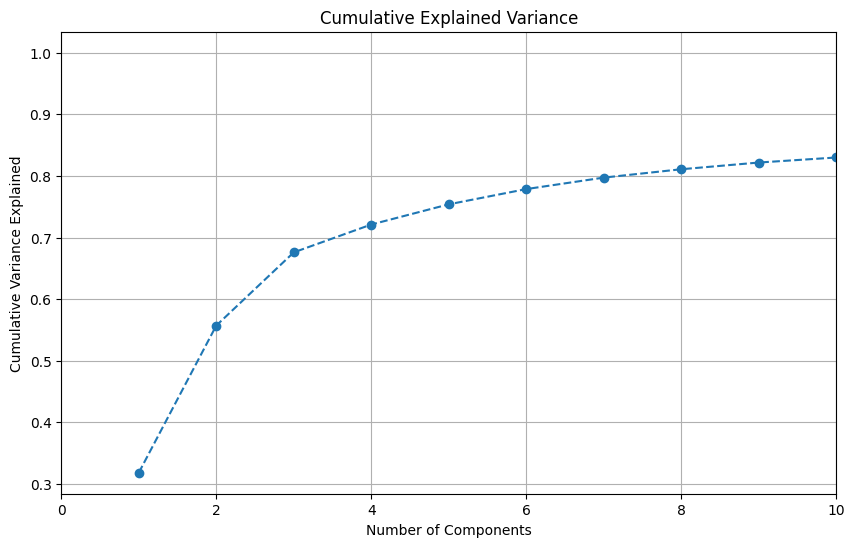

In [12]:
# Extract country names
countries = education_df['Country Name']

# Drop non-numeric columns (like country names and codes)
data_numeric = education_df.drop(['Country Name', 'Country Code'], axis=1)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.xlim(0, 10)  # Limiting x-axis to values from 0 to 10
plt.grid(True)
plt.show()


# Perform PCA with 8 components
pca = PCA(n_components=8)
pca_data = pca.fit_transform(data_scaled)

# Create DataFrame for PCA results
pca_columns = [f"PC{i}" for i in range(1, 9)]  # PC1 to PC8 column names
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

# Add 'Country Name' to the PCA DataFrame
pca_df['Country Name'] = countries.reset_index(drop=True)  # Resetting index to ensure alignment

# Make the Country Name column the first column
pca_df = pca_df[['Country Name'] + pca_columns]

# Rename country name as pca_name
pca_df.rename(columns={'Country Name': 'pca_name'}, inplace=True)

# Pivoting the acled DataFrame
# acled_df = acled_df.pivot(index='Country', columns='Year', values='Events')

# only keep column from 2018 to 2023
# acled_df = acled_df.loc[:, 2018:2023]

In [13]:
country_mapping = {
    'Antigua and Barbuda': 'Antigua & Barbuda',
    'Bahamas, The': 'Bahamas',
    "Cote d'Ivoire": "Ivory Coast",
    'Czech Republic': 'Czechia',
    'Congo, Dem. Rep.': 'DR Congo (Zaire)',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Iran, Islamic Rep.': 'Iran',
    'Micronesia, Fed. Sts.': 'Federated States of Micronesia',
    'Venezuela, RB': 'Venezuela',
    'Korea, Dem. People’s Rep.': 'North Korea',
    'Korea, Rep.': 'South Korea',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Yemen, Rep.': 'Yemen',
    'Macedonia, FYR': 'North Macedonia',
    'Timor-Leste': 'East Timor',
    'Russian Federation': 'Russia (Soviet Union)',
    'United States': 'United States of America',
    'Eswatini': 'Kingdom of eSwatini (Swaziland)',
    'Madagascar': 'Madagascar (Malagasy)',
    'Myanmar': 'Myanmar (Burma)',
    'Bolivia': 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Comoros': 'Comoros',
    'Congo, Rep.': 'Congo',
    'Germany': 'Germany',
    'Serbia': 'Serbia (Yugoslavia)',
    'Samoa': 'Samoa/Western Samoa',
    'Saint Kitts and Nevis': 'Saint Kitts and Nevis',
    'Saint Lucia': 'Saint Lucia',
    'Saint Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Syria': 'Syrian Arab Republic',
    'North Korea': "Korea, Democratic People's Republic of",
    'South Korea': 'Korea, Republic of',
    'Turkey': 'Türkiye',
    'Vietnam': 'Vietnam (North Vietnam)',
    'Laos': 'Lao PDR',
    'Kosovo': 'Kosovo',
    'American Samoa': 'American Samoa',
    'Aruba': 'Aruba',
    'Bermuda': 'Bermuda',
    'British Virgin Islands': 'British Virgin Islands',
    'Cambodia': 'Cambodia (Kampuchea)',
    'Cayman Islands': 'Cayman Islands',
    'Channel Islands': 'Channel Islands',
    'Curacao': 'Curacao',
    'Czechia': 'Czech Republic',
    'Faroe Islands': 'Faroe Islands',
    'French Polynesia': 'French Polynesia',
    'Gibraltar': 'Gibraltar',
    'Greenland': 'Greenland',
    'Guam': 'Guam',
    'Hong Kong SAR, China': 'Hong Kong SAR, China',
    'Isle of Man': 'Isle of Man',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao SAR, China',
    'New Caledonia': 'New Caledonia',
    'Northern Mariana Islands': 'Northern Mariana Islands',
    'Puerto Rico': 'Puerto Rico',
    'Sint Maarten (Dutch part)': 'Sint Maarten (Dutch part)',
    'Slovak Republic': 'Slovakia',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Martin (French part)': 'St. Martin (French part)',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Swaziland': 'Kingdom of eSwatini (Swaziland)',
    'Syrian Arab Republic': 'Syria',
    'Turks and Caicos Islands': 'Turks and Caicos Islands',
    'Türkiye': 'Turkey',
    'Virgin Islands (U.S.)': 'Virgin Islands (U.S.)',
    'West Bank and Gaza': 'West Bank and Gaza',
}

additional_country_mapping = {
    'Korea, Republic of': 'South Korea',
    'Korea, Democratic People\'s Republic of': 'North Korea',
    'Yemen': 'Yemen (North Yemen)',
    'Zimbabwe': 'Zimbabwe (Rhodesia)'
}
# Update the remaining mappings
remaining_country_mapping = {
    'Czechia': 'Czech Republic',
    'Hong Kong SAR, China': 'Hong Kong SAR, China',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao SAR, China',
    'Syrian Arab Republic': 'Syria',
    'Türkiye': 'Turkey',
    'West Bank and Gaza': 'West Bank and Gaza'
}

# Update with additional mappings
country_mapping.update(additional_country_mapping)

# Remove duplicates from remaining_country_mapping
remaining_country_mapping = {v: v for v in remaining_country_mapping.values()}

# Merge all mappings into one dictionary
country_mapping.update(remaining_country_mapping)

# Apply the updated mapping to pca_df
pca_df['pca_name'] = pca_df['pca_name'].map(lambda x: country_mapping.get(x, x))

# Check for remaining non-matches
remaining_non_matches = set(pca_df['pca_name'].unique()) - set(main_df['country_cy'].unique())
print("Remaining Non-Matches:")
print(sorted(remaining_non_matches))



Remaining Non-Matches:
['American Samoa', 'Arab World', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Curacao', 'East Asia & Pacific', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)', 'European Union', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guam', 'Heavily indebted poor countries (HIPC)', 'High income', 'Hong Kong SAR, China', 'Isle of Man', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income', 'Macao SAR, China', 'Middle East & North Africa', 'Middle East & North Africa (excluding high income)', 'Middle income', 'New Caledonia', 'North America', 'Northern Mariana Islands', 'OECD members', 'Puerto Rico', 'Sint Maarten (Dutch part)', 'South Asia', 'St. Martin (French part)', 'Sub-Saharan Africa', 'Sub-Sahara

In [14]:
# Merge the dataframes
prepcluster_df = pd.merge(gdp_df, pca_df, left_on='gdp_name', right_on='pca_name')

# Drop the redundant 'pca_name' column
prepcluster_df.drop(columns=['pca_name'], inplace=True)

# Select the GDP columns and principal components
gdp_features = prepcluster_df.loc[:, '1989':'2022'].copy()
pc_features = prepcluster_df.loc[:, 'PC1':'PC8'].copy()  # Adjust if you have more PCs

# Apply log transformation to GDP columns
log_transformed_gdp = gdp_features.applymap(lambda x: np.log1p(x))

# Standardize the log-transformed GDP features
scaler = StandardScaler()
standardized_log_gdp = scaler.fit_transform(log_transformed_gdp)

# Standardize the principal components
standardized_pcs = scaler.fit_transform(pc_features)

# Combine the standardized log-transformed GDP and principal components
combined_features = np.hstack((standardized_log_gdp, standardized_pcs))

C:\Users\troen\AppData\Local\Temp\ipykernel_28216\3655312676.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed_gdp = gdp_features.applymap(lambda x: np.log1p(x))


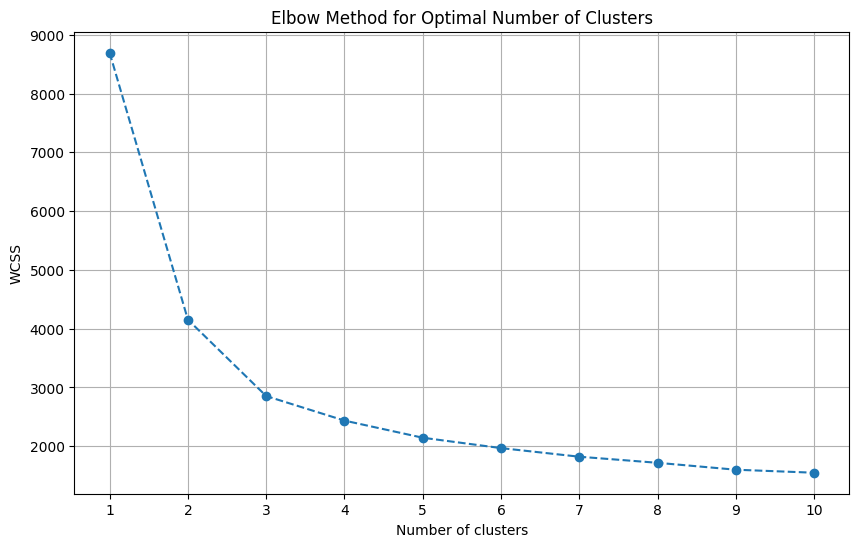

In [15]:
# Function to calculate WCSS for different number of clusters
def calculate_wcss(data):
    wcss = []
    for n in range(1, 11):  # You can adjust the range if needed
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS
wcss = calculate_wcss(combined_features)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

optimal_clusters = 5  # Adjust based on elbow plot

# Run K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_features)

# Add the cluster labels to your original DataFrame
prepcluster_df['Cluster'] = clusters

# Create a new DataFrame with 'gdp_name' and 'Cluster'
country_clusters_df = prepcluster_df[['gdp_name', 'Cluster']]


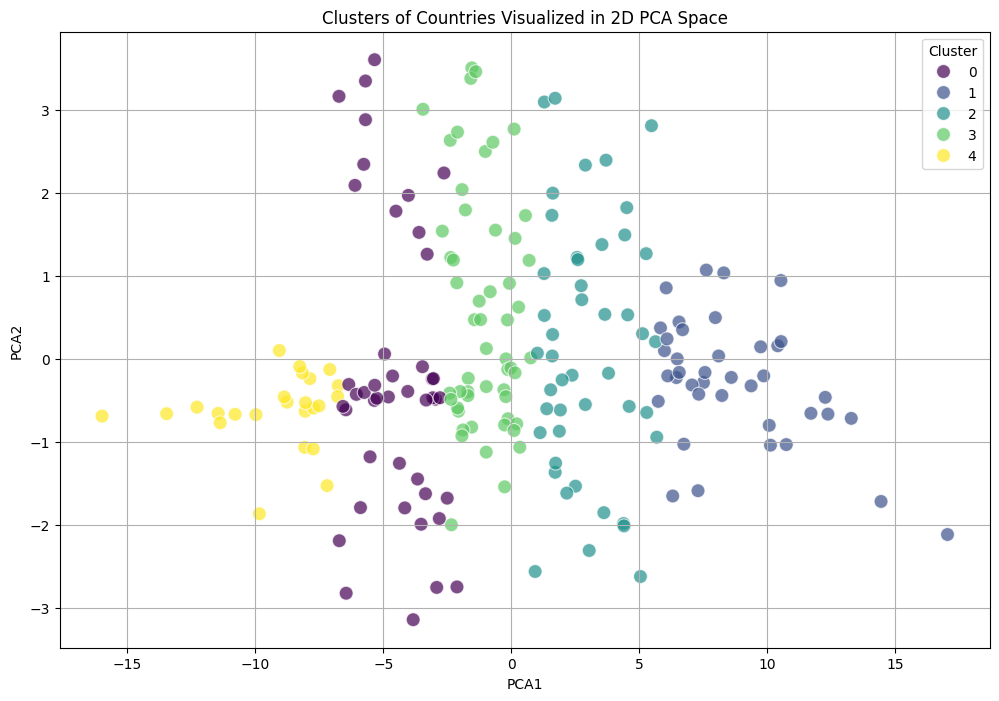

Cluster 0:
['Niger' 'French Polynesia' 'Sierra Leone' 'San Marino' 'Suriname'
 'Kingdom of eSwatini (Swaziland)' 'Sint Maarten (Dutch part)' 'Chad'
 'Togo' 'Tajikistan']

Cluster 1:
['Portugal' 'Russia (Soviet Union)' 'Saudi Arabia' 'Singapore' 'Sweden'
 'Thailand' 'Turkey' 'United States of America' 'Venezuela' 'South Africa']

Cluster 2:
['Sudan' 'Serbia (Yugoslavia)' 'Slovakia' 'Slovenia' 'Syria' 'Tunisia'
 'Ukraine' 'Uruguay' 'Uzbekistan' 'Vietnam (North Vietnam)']

Cluster 3:
['Senegal' 'El Salvador' 'Somalia' 'South Sudan' 'Turkmenistan'
 'Trinidad and Tobago' 'Tanzania' 'Uganda' 'Zambia' 'Zimbabwe (Rhodesia)']

Cluster 4:
['Solomon Islands' 'Sao Tome and Principe' 'Seychelles'
 'Turks and Caicos Islands' 'East Timor' 'Tonga' 'Tuvalu'
 'Saint Vincent and the Grenadines' 'Vanuatu' 'Samoa/Western Samoa']



In [16]:
# Reduce the combined features to 2 dimensions using PCA for visualization
pca_visual = PCA(n_components=2)
pca_2d = pca_visual.fit_transform(combined_features)

# Create a DataFrame with the 2D PCA results
pca_df = pd.DataFrame(data=pca_2d, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['gdp_name'] = prepcluster_df['gdp_name']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters of Countries Visualized in 2D PCA Space')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

for cluster in range(optimal_clusters):
    print(f"Cluster {cluster}:")
    cluster_df = prepcluster_df.loc[prepcluster_df['Cluster'] == cluster, 'gdp_name']
    if len(cluster_df) > 5:
        print(cluster_df.tail(10).values)
    else:
        print(cluster_df.values)
    print()

In [17]:

# Step 1: Ensure there are no conflicts by renaming columns if necessary
country_clusters_df = country_clusters_df.rename(columns={'gdp_name': 'country_cy', 'Cluster': 'Cluster_cluster'})

# Step 2: Perform the merge with custom suffixes to avoid conflicts
main_df = pd.merge(main_df, country_clusters_df, on='country_cy', how='left', suffixes=('', '_cluster'))

# Step 3: Remove rows where 'Cluster_cluster' is NaN
main_df = main_df[main_df['Cluster_cluster'].notna()]

# Step 4: Remove the unnecessary columns
columns_to_drop = ['country_id_cy', 'sb_dyad_ids_cy', 'ns_dyad_ids_cy', 'os_dyad_ids_cy','cumulative_total_deaths_unknown_in_orgvio_cy']
main_df = main_df.drop(columns=columns_to_drop)

main_df = main_df.rename(columns={'Cluster_cluster': 'gdp_education'})




In [18]:
# Ensure the data is sorted by country and year
main_df = main_df.sort_values(by=['country_cy', 'year_cy'])

# Initialize a new column for the years since last civilian death
main_df['years_since_last_civilian_death'] = None

# Dictionary to keep track of the last year a civilian death occurred for each country
last_death_year_civilian = {}
# Dictionary to keep track of whether deaths were recorded in the current year
current_year_deaths_civilian = {}

# Iterate through the DataFrame
for index, row in main_df.iterrows():
    country = row['country_cy']
    year = row['year_cy']
    deaths_civilian = row['cumulative_total_deaths_civilians_in_orgvio_cy']
    
    # Check if the country has been encountered before
    if country in last_death_year_civilian:
        if deaths_civilian > 0:
            # Set the years since last civilian death to the same as last year as we don't know this year's deaths yet
            main_df.at[index, 'years_since_last_civilian_death'] = year - last_death_year_civilian[country]
            # Update the last death year to the current year
            last_death_year_civilian[country] = year
            # Set flag for current year deaths
            current_year_deaths_civilian[country] = True
        else:
            if country in current_year_deaths_civilian and current_year_deaths_civilian[country]:
                # This is the year after deaths occurred, so reset the counter
                main_df.at[index, 'years_since_last_civilian_death'] = 0
                last_death_year_civilian[country] = year
                current_year_deaths_civilian[country] = False
            else:
                # Calculate the difference between the current year and the last recorded year of death
                main_df.at[index, 'years_since_last_civilian_death'] = year - last_death_year_civilian[country]
    else:
        if deaths_civilian == 0:
            # Initialize with the difference from 1989 as there is no prior year of death
            main_df.at[index, 'years_since_last_civilian_death'] = year - 1989
        else:
            # Initialize with the difference from 1989 and set the flag for current year deaths
            main_df.at[index, 'years_since_last_civilian_death'] = year - 1989
            last_death_year_civilian[country] = year
            current_year_deaths_civilian[country] = True

# Fill the missing values with 0 (this might not be necessary if logic is correct)
main_df['years_since_last_civilian_death'] = main_df['years_since_last_civilian_death'].fillna(0)

# Convert 'years_since_last_civilian_death' to integer type for better handling
main_df['years_since_last_civilian_death'] = main_df['years_since_last_civilian_death'].astype(int)

### Also do that for cumulative_best

# Dictionary to keep track of the last year a death occurred for each country
last_death_year_best = {}
# Dictionary to keep track of whether deaths were recorded in the current year
current_year_deaths = {}

# Iterate through the DataFrame
for index, row in main_df.iterrows():
    country = row['country_cy']
    year = row['year_cy']
    deaths_best = row['cumulative_total_deaths_in_orgvio_best_cy']
    
    # Check if the country has been encountered before
    if country in last_death_year_best:
        if deaths_best > 0:
            # Set the years since last death to the same as last year as we don't know this year's deaths yet
            main_df.at[index, 'years_since_last_death'] = year - last_death_year_best[country]
            # Update the last death year to the current year
            last_death_year_best[country] = year
            # Set flag for current year deaths
            current_year_deaths[country] = True
        else:
            if country in current_year_deaths and current_year_deaths[country]:
                # This is the year after deaths occurred, so reset the counter
                main_df.at[index, 'years_since_last_death'] = 0
                last_death_year_best[country] = year
                current_year_deaths[country] = False
            else:
                # Calculate the difference between the current year and the last recorded year of death
                main_df.at[index, 'years_since_last_death'] = year - last_death_year_best[country]
    else:
        if deaths_best == 0:
            # Initialize with the difference from 1989 as there is no prior year of death
            main_df.at[index, 'years_since_last_death'] = year - 1989
        else:
            # Initialize with the difference from 1989 and set the flag for current year deaths
            main_df.at[index, 'years_since_last_death'] = year - 1989
            last_death_year_best[country] = year
            current_year_deaths[country] = True

# Fill the missing values with 0 (this might not be necessary if logic is correct)
main_df['years_since_last_death'] = main_df['years_since_last_death'].fillna(0)

# Convert 'years_since_last_death' to integer type for better handling
main_df['years_since_last_death'] = main_df['years_since_last_death'].astype(int)

C:\Users\troen\AppData\Local\Temp\ipykernel_28216\1843409872.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_df['years_since_last_civilian_death'] = main_df['years_since_last_civilian_death'].fillna(0)


In [ ]:
# Define the new column order
new_column_order = [
    'country_cy', 'gdp_education', 'year_cy', 'region_cy', 'sb_dyad_count_cy',
    'incompatibility', 'sb_intrastate_main_govt_inv_incomp_cy',
    'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'org',
    'os_dyad_count_cy', 'os_main_govt_inv_cy', 'os_any_govt_inv_cy',
    'os_nsgroup_inv_cy', 'years_since_last_civilian_death', 'years_since_last_death',
    'cumulative_total_deaths_parties_in_orgvio_cy', 'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]

# Reorder the DataFrame columns
main_df = main_df[new_column_order]

In [ ]:
main_df['country_cy']=main_df['country_cy'].astype('category').cat.codes
main_df['region_cy']=main_df['region_cy'].astype('category').cat.codes

In [85]:

################################################
# START OF SUPERVISED LEARNING
################################################

# Define the cutoff year for training and testing
cutoff_year = 2017  

# Split the data
train_df = main_df[main_df['year_cy'] < cutoff_year]
test_df = main_df[main_df['year_cy'] >= cutoff_year]

# Define features (X) and targets (y)
x_train = train_df.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train = train_df[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

X_test = test_df.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test = test_df[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

# Identify categorical and numeric columns
categorical_features = ['country_cy', 'region_cy']
numeric_features = [col for col in x_train.columns if col not in categorical_features]

# Create a column transformer with OneHotEncoder for categorical features and StandardScaler for numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fit and transform the training data
X_train_scaled = preprocessor.fit_transform(x_train)
X_test_scaled = preprocessor.transform(X_test)

# Scale the target variables
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
input_dim = X_train_scaled.shape[1]


### Model with all the features
# Define the custom learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return float(lr * tf.math.exp(-0.1))  # Decay the learning rate exponentially
    
# Define your model
model_1 = Sequential(name= "full_neural_3")

# Add layers to the model
model_1.add(Dense(108, activation='linear', input_shape=(input_dim,)))
model_1.add(Dropout(0.1))
model_1.add(Dense(54, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(6, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(3, activation= "relu"))
# Compile the model
model_1.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Print the model summary
model_1.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = LearningRateScheduler(lr_scheduler)

# Training the model
history = model_1.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, mae = model_1.evaluate(X_test_scaled, y_test_scaled)
print(f"Mean Absolute Error on test data: {mae}")

# Make predictions
y_pred_scaled = model_1.predict(X_test_scaled)

# Clip predictions to ensure non-negative values
y_pred_scaled = np.clip(y_pred_scaled, 0, None)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate additional performance metrics
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred_scaled)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

# Scatter plots: Actual vs Predicted values for each target variable
targets = ['Parties in Orgvio', 'Civilians in Orgvio', 'Best Estimate']
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_scaled[:, i], y_pred_scaled[:, i], alpha=0.3)
    plt.plot([min(y_test_scaled[:, i]), max(y_test_scaled[:, i])], [min(y_test_scaled[:, i]), max(y_test_scaled[:, i])], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Scatter plot for {target}')
    plt.show()

# Residual plots for each target variable
residuals = y_test_scaled - y_pred_scaled
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_pred_scaled[:, i], residuals[:, i], alpha=0.3)
    plt.hlines(0, min(y_pred_scaled[:, i]), max(y_pred_scaled[:, i]), colors='red')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'Residual plot for {target}')
    plt.show()

# Learning curves: Training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Comparison table of actual vs predicted values for the first few samples
comparison_df = pd.DataFrame({
    'Actual_Parties_in_Orgvio': y_test.iloc[:, 0].values,
    'Predicted_Parties_in_Orgvio': scaler_y.inverse_transform(y_pred_scaled)[:, 0],
    'Actual_Civilians_in_Orgvio': y_test.iloc[:, 1].values,
    'Predicted_Civilians_in_Orgvio': scaler_y.inverse_transform(y_pred_scaled)[:, 1],
    'Actual_Best_Estimate': y_test.iloc[:, 2].values,
    'Predicted_Best_Estimate': scaler_y.inverse_transform(y_pred_scaled)[:, 2]
})

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train_scaled, model_1.predict(X_train_scaled)))
train_mae = mean_absolute_error(y_train_scaled, model_1.predict(X_train_scaled))
train_r2 = r2_score(y_train_scaled, model_1.predict(X_train_scaled))

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
test_mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
test_r2 = r2_score(y_test_scaled, y_pred_scaled)

# Create DataFrame for comparison
comparison_metrics_df = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse, train_mae, train_r2],
    'Test': [test_rmse, test_mae, test_r2]
})

print(comparison_metrics_df)

test_loss, test_acc = model_1.evaluate(X_test_scaled, y_test_scaled, verbose=2)
print("Test accuracy:", test_acc)

In [ ]:
# Code the number of times all the columns after region_cy are 0
print(len(main_df[(main_df.loc[:, 'sb_dyad_count_cy':] == 0).all(axis=1)]))

In [21]:
################################################
################################################
# Define the cutoff year for training and testing
cutoff_year_2 = 2017


# Split the data
train_df_2 = main_df[main_df['year_cy'] < cutoff_year_2]
test_df_2 = main_df[main_df['year_cy'] >= cutoff_year_2]

# Test avec et sans
train_df_2 = shuffle(train_df_2, random_state=42)

# Define features (X) and targets (y)
x_train_2 = train_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])

y_train_2 = train_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

x_test_2 = test_df_2.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_2 = test_df_2[['cumulative_total_deaths_in_orgvio_best_cy']]

# Identify categorical and numeric columns
categorical_features_2 = ['country_cy', 'region_cy']
numeric_features_2 = [col for col in x_train_2.columns if col not in categorical_features_2]

# Create a column transformer with OneHotEncoder for categorical features and StandardScaler for numeric features
#preprocessor_2 = ColumnTransformer(
#    transformers=[
        #('num', StandardScaler(), numeric_features_2),
 #       ('cat', OneHotEncoder(), categorical_features_2)
   # ])

# Fit and transform the training data
#x_train_scaled_2 = preprocessor_2.fit_transform(x_train_2)
#x_test_scaled_2 = preprocessor_2.transform(x_test_2)

# Scale the target variables
#scaler_y_2 = StandardScaler()
#y_train_2 = scaler_y_2.fit_transform(y_train_2)
#y_test_2 = scaler_y_2.transform(y_test_2)

C:\Users\troen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 108)            │         1,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 54)             │         5,886 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,687 (37.84 KB)

 Trainable params: 9,687 (37.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 531.0987 - mean_absolute_error: 531.0987 - val_loss: 583.4171 - val_mean_absolute_error: 583.4171 - learning_rate: 0.0010
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 519.8980 - mean_absolute_error: 519.8980 - val_loss: 583.4150 - val_mean_absolute_error: 583.4150 - learning_rate: 0.0010
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 771.5535 - mean_absolute_error: 771.5535 - val_loss: 583.4133 - val_mean_absolute_error: 583.4133 - learning_rate: 0.0010
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 745.9039 - mean_absolute_error: 745.9039 - val_loss: 583.4132 - val_mean_absolute_error: 583.4132 - learning_rate: 0.0010
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 337.9016 - mean_absolute_error: 337.9016 - val_loss: 583.4133 - val_mean_absolute_error: 583.4133 - learning_rate: 0.0010
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 469.2148 - mean_absolute

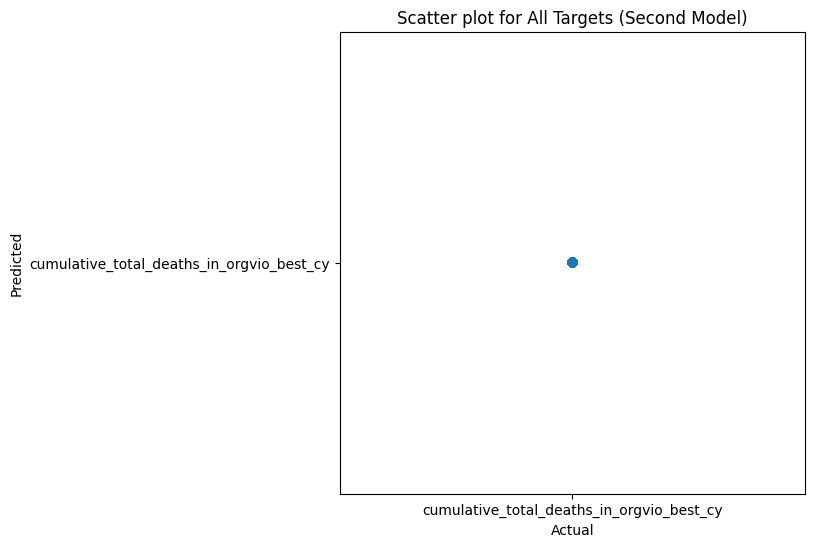

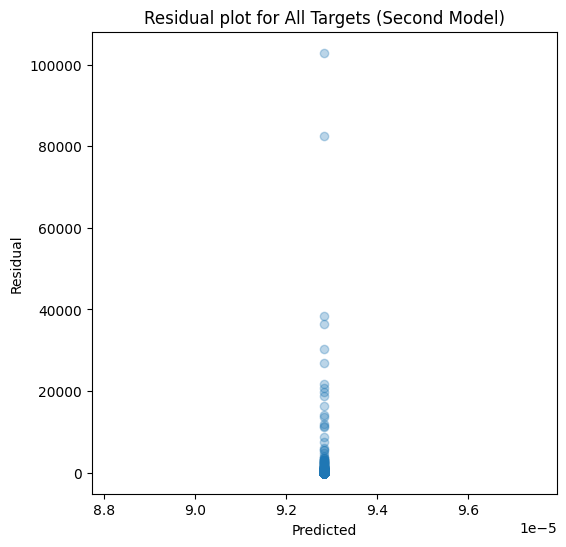

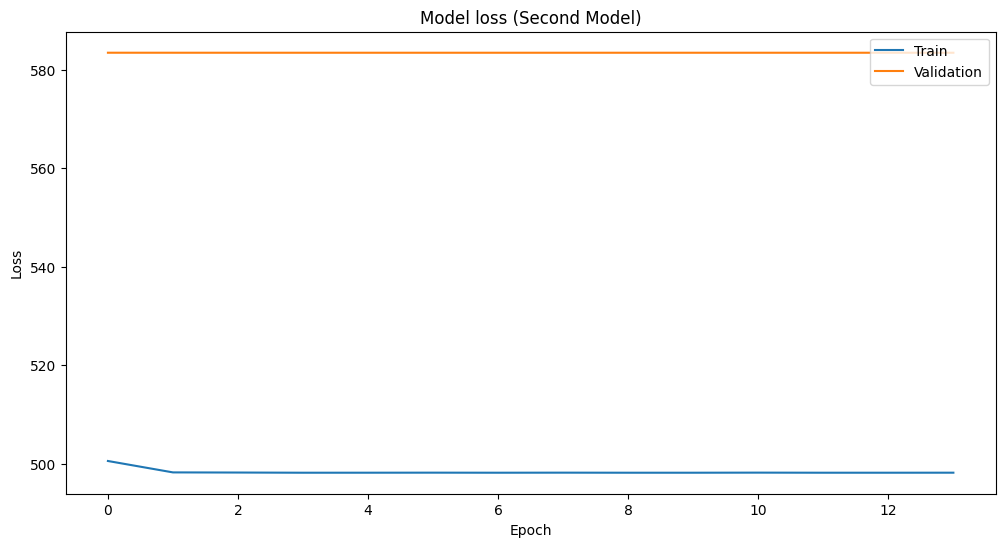

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
     Metrics      Training         Test
0       RMSE  10968.716587  4669.993306
1        MAE    498.145854   583.413229
2  R-Squared     -0.002067    -0.015854


In [25]:
# Define the input dimension for the second model
input_dim_2 = x_train_2.shape[1]

# Define the custom learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return float(lr * tf.math.exp(-0.1))  # Decay the learning rate exponentially

# Define your second model
model_2 = Sequential()

# Add layers to the second model
model_2.add(Dense(108, activation='linear', input_shape=(input_dim_2,)))
model_2.add(Dropout(0.1))
model_2.add(Dense(54, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(6, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(1, activation="linear"))

# Compile the second model
model_2.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Print the second model summary
model_2.summary()

# Define callbacks for the second model
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_2 = LearningRateScheduler(lr_scheduler)

# Training the second model
history_2 = model_2.fit(
    x_train_2, y_train_2,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_2, y_test_2),
    callbacks=[early_stopping_2, reduce_lr_2]
)

# Evaluate the second model
loss_2, mae_2 = model_2.evaluate(x_test_2, y_test_2)
print(f"Mean Absolute Error on test data (Second Model): {mae_2}")

# Make predictions with the second model
y_pred_2 = model_2.predict(x_test_2)

# Clip predictions to ensure non-negative values for the second model
# y_pred_scaled_2 = np.clip(y_pred_scaled_2, 0, None)

# Inverse transform predictions for the second model
# y_pred_2 = scaler_y_2.inverse_transform(y_pred_scaled_2)

# Calculate additional performance metrics for the second model
mse_2 = mean_squared_error(y_test_2, y_pred_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test_2, y_pred_2)

print(f"Mean Squared Error (Second Model): {mse_2}")
print(f"Root Mean Squared Error (Second Model): {rmse_2}")
print(f"R-squared (Second Model): {r2_2}")

# Scatter plots: Actual vs Predicted values for each target variable for the second model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_2, y_pred_2, alpha=0.3)
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for All Targets (Second Model)')
plt.show()

# Calculate residuals
residuals_2 = y_test_2 - y_pred_2

# Residual plots for each target variable for the second model
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_2, residuals_2, alpha=0.3)
plt.hlines(0, min(y_pred_2), max(y_pred_2), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for All Targets (Second Model)')
plt.show()

# Learning curves: Training and validation loss over epochs for the second model
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss (Second Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Flatten the ndarray
y_pred_2_flat = y_pred_2.flatten()

# Construct the DataFrame
comparison_df_2 = pd.DataFrame({
    'Actual_Best_Estimate': y_test_2.iloc[:, 0].values,
    'Predicted_Best_Estimate': y_pred_2_flat
})

# Calculate metrics for training set for the second model
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, model_2.predict(x_train_2)))
train_mae_2 = mean_absolute_error(y_train_2, model_2.predict(x_train_2))
train_r2_2 = r2_score(y_train_2, model_2.predict(x_train_2))

# Calculate metrics for test set for the second model
test_rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_2))
test_mae_2 = mean_absolute_error(y_test_2, y_pred_2)
test_r2_2 = r2_score(y_test_2, y_pred_2)

# Create DataFrame for comparison for the second model
comparison_metrics_df_2 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_2, train_mae_2, train_r2_2],
    'Test': [test_rmse_2, test_mae_2, test_r2_2]
})

print(comparison_metrics_df_2)

C:\Users\troen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_248 (Dense)               │ (None, 108)            │        22,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 54)             │         5,886 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 32)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,646 (119.71 KB)

 Trainable params: 30,646 (119.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0508 - mean_absolute_error: 0.0508 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315 - learning_rate: 0.0010
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321 - learning_rate: 0.0010
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0429 - mean_absolute_error: 0.0429 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315 - learning_rate: 0.0010
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308 - learning_rate: 0.0010
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - mean_absolute_error: 0.0244 - val_loss: 0.0263 - val_mean_absolute_error: 0.0263 - learning_rate: 0.0010
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0657 - mean_absolute_error: 0.0657 - val_loss: 0.0270 - val_me

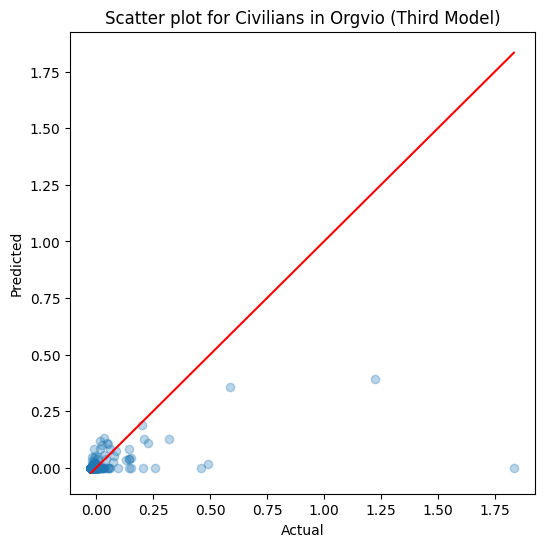

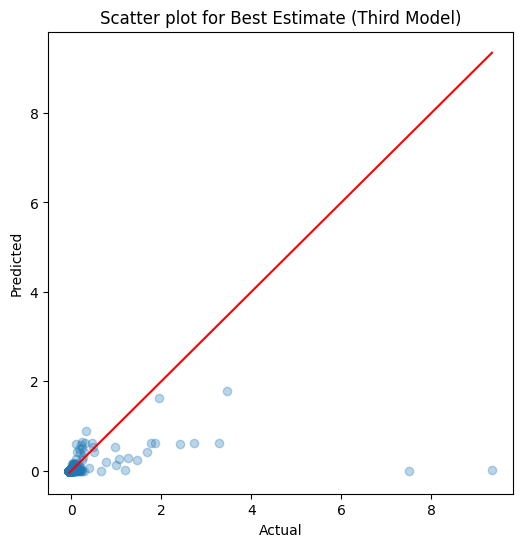

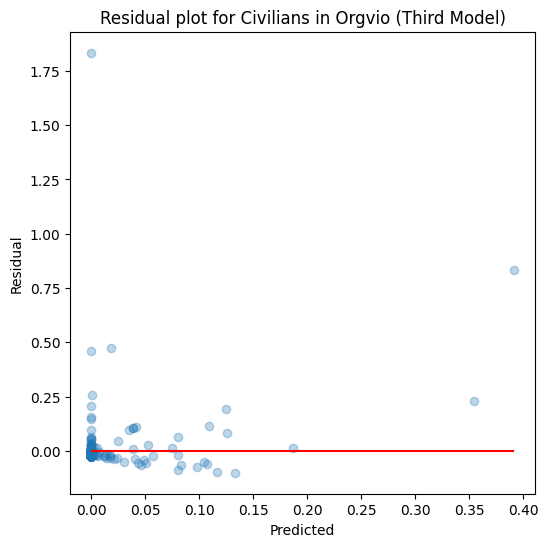

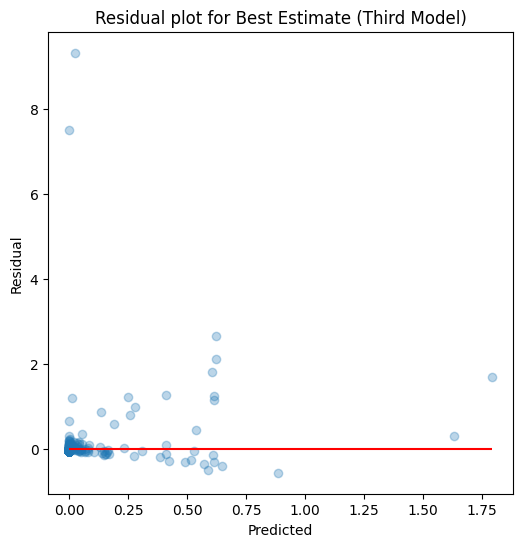

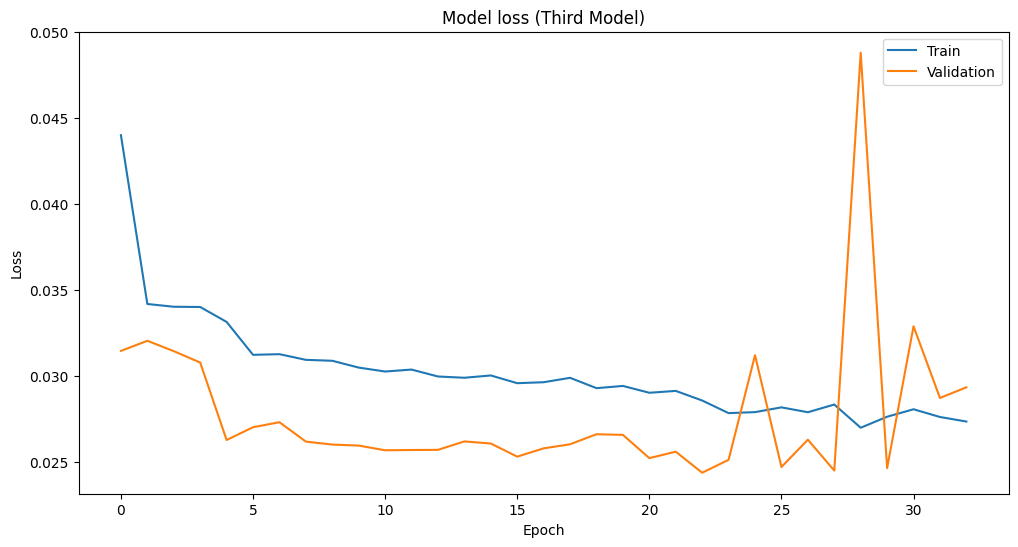

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
     Metrics  Training      Test
0       RMSE  0.992666  0.280179
1        MAE  0.027562  0.052542
2  R-Squared  0.014615  0.159792


In [92]:
################################################

################################################

# Subset on which we train the model:
# Only rows where something happened
subset_main_df = main_df[(main_df.loc[:, 'sb_dyad_count_cy':'cumulative_total_deaths_in_orgvio_best_cy'] != 0).any(axis=1)]

# Define the cutoff year for training and testing for the third model
cutoff_year_3 = 2017  

# Split the data for the third model
train_df_3 = main_df[main_df['year_cy'] < cutoff_year_3]
test_df_3 = main_df[main_df['year_cy'] >= cutoff_year_3 ]

# Define features (X) and targets (y) for the third model
x_train_3 = train_df_3.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train_3 = train_df_3[[
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

x_test_3 = test_df_3.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_3 = test_df_3[[
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

# Identify categorical and numeric columns for the third model
categorical_features_3 = ['country_cy', 'region_cy']
numeric_features_3 = [col for col in x_train_3.columns if col not in categorical_features_3]

# Modify the definition of the preprocessor for the third model to handle unknown categories
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_3),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_3)
    ])

# Fit and transform the training data for the third model
x_train_scaled_3 = preprocessor_3.fit_transform(x_train_3)
x_test_scaled_3 = preprocessor_3.transform(x_test_3)

# Scale the target variables for the third model
scaler_y_3 = StandardScaler()
y_train_scaled_3 = scaler_y_3.fit_transform(y_train_3)
y_test_scaled_3 = scaler_y_3.transform(y_test_3)

# Define the input dimension for the third model
input_dim_3 = x_train_scaled_3.shape[1]


# Define the custom learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return float(lr * tf.math.exp(-0.1))  # Decay the learning rate exponentially


# Define your third model
model_3 = Sequential()

# Add layers to the third model
model_3.add(Dense(108, activation='linear', input_shape=(input_dim_3,)))
model_3.add(Dropout(0.1))  # Adding more dropout for regularization
model_3.add(Dense(54, activation='relu'))
model_3.add(Dropout(0.1))  # Adding more dropout for regularization
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.1))  # Adding more dropout for regularization
model_3.add(Dense(6, activation='relu'))
model_3.add(Dropout(0.1))  # Adding more dropout for regularization
model_3.add(Dense(2, activation='linear'))


# Compile the third model
model_3.compile(optimizer='adam', loss= "mean_absolute_error", metrics=['mean_absolute_error'])

# Print the third model summary
model_3.summary()

# Define callbacks for the third model
early_stopping_3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_3 = LearningRateScheduler(lr_scheduler)

# Training the model
history_3 = model_3.fit(
    x_train_scaled_3, y_train_scaled_3,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_scaled_3, y_test_scaled_3),
    callbacks=[early_stopping_3, reduce_lr_3]
)

# Evaluate the third model
loss_3, mae_3 = model_3.evaluate(x_test_scaled_3, y_test_scaled_3)
print(f"Mean Absolute Error on test data (Third Model): {mae_3}")

# Make predictions with the third model
y_pred_scaled_3 = model_3.predict(x_test_scaled_3)

# Clip predictions to ensure non-negative values for the third model
y_pred_scaled_3 = np.clip(y_pred_scaled_3, 0, None)


# Inverse transform predictions for the third model
y_pred_3 = scaler_y_3.inverse_transform(y_pred_scaled_3)

# Calculate additional performance metrics for the third model
mse_3 = mean_squared_error(y_test_scaled_3, y_pred_scaled_3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test_scaled_3, y_pred_scaled_3)

print(f"Mean Squared Error (Third Model): {mse_3}")
print(f"Root Mean Squared Error (Third Model): {rmse_3}")
print(f"R-squared (Third Model): {r2_3}")

# Scatter plots: Actual vs Predicted values for each target variable for the third model
targets_3 = [ 'Civilians in Orgvio', 'Best Estimate']
for i, target_3 in enumerate(targets_3):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_scaled_3[:, i], y_pred_scaled_3[:, i], alpha=0.3)
    plt.plot([min(y_test_scaled_3[:, i]), max(y_test_scaled_3[:, i])], [min(y_test_scaled_3[:, i]), max(y_test_scaled_3[:, i])], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Scatter plot for {target_3} (Third Model)')
    plt.show()

# Residual plots for each target variable for the third model
residuals_3 = y_test_scaled_3 - y_pred_scaled_3
for i, target_3 in enumerate(targets_3):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_pred_scaled_3[:, i], residuals_3[:, i], alpha=0.3)
    plt.hlines(0, min(y_pred_scaled_3[:, i]), max(y_pred_scaled_3[:, i]), colors='red')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'Residual plot for {target_3} (Third Model)')
    plt.show()

# Learning curves: Training and validation loss over epochs for the third model
plt.figure(figsize=(12, 6))
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss (Third Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Comparison table of actual vs predicted values for the first few samples for the third model
comparison_df_3 = pd.DataFrame({
    'Actual_Civilians_in_Orgvio': y_test_3.iloc[:, 0].values,
    'Predicted_Civilians_in_Orgvio': scaler_y_3.inverse_transform(y_pred_scaled_3)[:, 0],
    'Actual_Best_Estimate': y_test_3.iloc[:, 1].values,
    'Predicted_Best_Estimate': scaler_y_3.inverse_transform(y_pred_scaled_3)[:, 1]
})

# Calculate metrics for training set for the third model
train_rmse_3 = np.sqrt(mean_squared_error(y_train_scaled_3, model_3.predict(x_train_scaled_3)))
train_mae_3 = mean_absolute_error(y_train_scaled_3, model_3.predict(x_train_scaled_3))
train_r2_3 = r2_score(y_train_scaled_3, model_3.predict(x_train_scaled_3))

# Calculate metrics for test set for the third model
test_rmse_3 = np.sqrt(mean_squared_error(y_test_scaled_3, y_pred_scaled_3))
test_mae_3 = mean_absolute_error(y_test_scaled_3, y_pred_scaled_3)
test_r2_3 = r2_score(y_test_scaled_3, y_pred_scaled_3)

# Create DataFrame for comparison for the third model
comparison_metrics_df_3 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_3, train_mae_3, train_r2_3],
    'Test': [test_rmse_3, test_mae_3, test_r2_3]
})

print(comparison_metrics_df_3)


C:\Users\troen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ (None, 108)            │        22,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 54)             │         5,886 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,646 (119.71 KB)

 Trainable params: 30,646 (119.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0715 - mean_absolute_error: 0.0715 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569 - learning_rate: 0.0010
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1109 - mean_absolute_error: 0.1109 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569 - learning_rate: 0.0010
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0699 - mean_absolute_error: 0.0699 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569 - learning_rate: 0.0010
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0612 - mean_absolute_error: 0.0612 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569 - learning_rate: 0.0010
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0575 - mean_absolute_error: 0.0575 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569 - learning_rate: 0.0010
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0502 - mean_absolute_error: 0.0502 - val_loss: 0.0569 - val_me

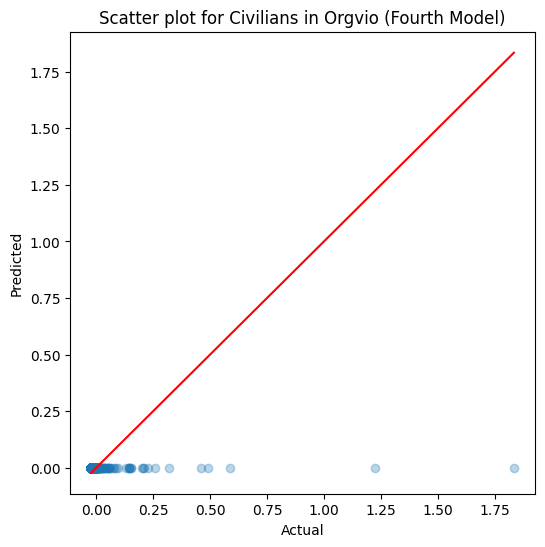

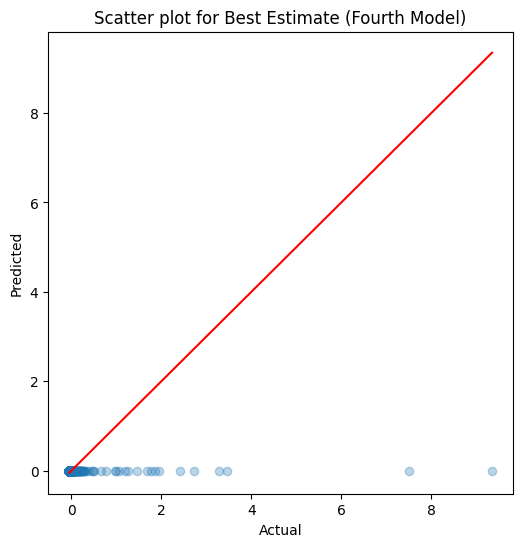

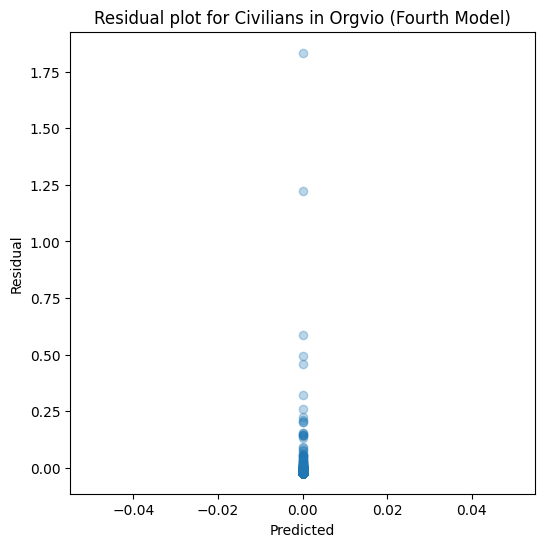

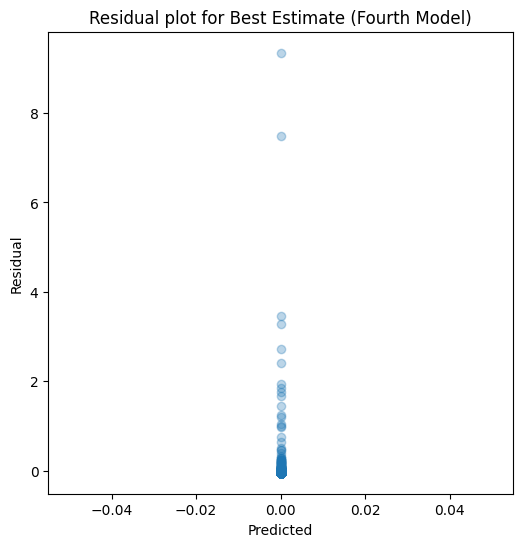

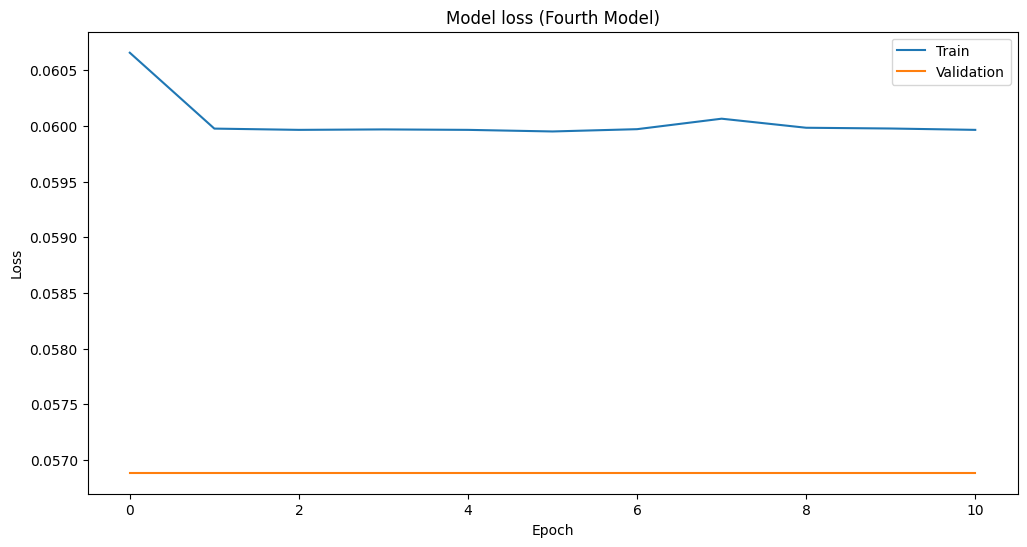

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
     Metrics      Training      Test
0       RMSE  1.000000e+00  0.303891
1        MAE  5.996566e-02  0.056886
2  R-Squared  1.548761e-14 -0.014742


In [58]:

# Define the cutoff year for training and testing for the fourth model
cutoff_year_4 = 2017  

# Split the data for the fourth model
train_df_4 = main_df[main_df['year_cy'] < cutoff_year_4]
test_df_4 = main_df[main_df['year_cy'] >= cutoff_year_4 ]

# Define features (X) and targets (y) for the fourth model
x_train_4 = train_df_4.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train_4 = train_df_4[[
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

x_test_4 = test_df_4.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_4 = test_df_4[[
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

# Identify categorical and numeric columns for the fourth model
categorical_features_4 = ['country_cy', 'region_cy']
numeric_features_4 = [col for col in x_train_4.columns if col not in categorical_features_4]

# Modify the definition of the preprocessor for the fourth model to handle unknown categories
preprocessor_4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_4)
    ])

# Fit and transform the training data for the fourth model
x_train_scaled_4 = preprocessor_4.fit_transform(x_train_4)
x_test_scaled_4 = preprocessor_4.transform(x_test_4)

# Scale the target variables for the fourth model
scaler_y_4 = StandardScaler()
y_train_scaled_4 = scaler_y_4.fit_transform(y_train_4)
y_test_scaled_4 = scaler_y_4.transform(y_test_4)

# Define the input dimension for the fourth model
input_dim_4 = x_train_scaled_4.shape[1]

# Define a function to schedule the learning rate
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# Define your fourth model
model_4 = Sequential()

# Add layers to the fourth model
model_4.add(Dense(108, activation='linear', input_shape=(input_dim_4,)))
model_4.add(Dropout(0.1))  # Adding more dropout for regularization
model_4.add(Dense(54, activation='relu'))
model_4.add(Dropout(0.1))  # Adding more dropout for regularization
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.1))  # Adding more dropout for regularization
model_4.add(Dense(6, activation='relu'))
model_4.add(Dropout(0.1))  # Adding more dropout for regularization
model_4.add(Dense(2, activation='relu'))

# Compile the fourth model
model_4.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Print the fourth model summary
model_4.summary()

# Define callbacks for the fourth model
early_stopping_4 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_4 = LearningRateScheduler(lr_scheduler)

# Training the fourth model
history_4 = model_4.fit(
    x_train_scaled_4, y_train_scaled_4,
    epochs=100,
    batch_size=16,
    validation_data=(x_test_scaled_4, y_test_scaled_4),
    callbacks=[early_stopping_4, reduce_lr_4]
)

# Evaluate the fourth model
loss_4, mae_4 = model_4.evaluate(x_test_scaled_4, y_test_scaled_4)
print(f"Mean Absolute Error on test data (Fourth Model): {mae_4}")

# Make predictions with the fourth model
y_pred_scaled_4 = model_4.predict(x_test_scaled_4)

# Clip predictions to ensure non-negative values for the fourth model
y_pred_scaled_4 = np.clip(y_pred_scaled_4, 0, None)

# Inverse transform predictions for the fourth model
y_pred_4 = scaler_y_4.inverse_transform(y_pred_scaled_4)

# Calculate additional performance metrics for the fourth model
mse_4 = mean_squared_error(y_test_scaled_4, y_pred_scaled_4)
rmse_4 = np.sqrt(mse_4)
r2_4 = r2_score(y_test_scaled_4, y_pred_scaled_4)

print(f"Mean Squared Error (Fourth Model): {mse_4}")
print(f"Root Mean Squared Error (Fourth Model): {rmse_4}")
print(f"R-squared (Fourth Model): {r2_4}")

# Scatter plots: Actual vs Predicted values for each target variable for the fourth model
targets_4 = ['Civilians in Orgvio', 'Best Estimate']
for i, target_4 in enumerate(targets_4):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_scaled_4[:, i], y_pred_scaled_4[:, i], alpha=0.3)
    plt.plot([min(y_test_scaled_4[:, i]), max(y_test_scaled_4[:, i])], [min(y_test_scaled_4[:, i]), max(y_test_scaled_4[:, i])], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Scatter plot for {target_4} (Fourth Model)')
    plt.show()

# Residual plots for each target variable for the fourth model
residuals_4 = y_test_scaled_4 - y_pred_scaled_4
for i, target_4 in enumerate(targets_4):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_pred_scaled_4[:, i], residuals_4[:, i], alpha=0.3)
    plt.hlines(0, min(y_pred_scaled_4[:, i]), max(y_pred_scaled_4[:, i]), colors='red')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'Residual plot for {target_4} (Fourth Model)')
    plt.show()

# Learning curves: Training and validation loss over epochs for the fourth model
plt.figure(figsize=(12, 6))
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss (Fourth Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Comparison table of actual vs predicted values for the first few samples for the fourth model
comparison_df_4 = pd.DataFrame({
    'Actual_Civilians_in_Orgvio': y_test_4.iloc[:, 0].values,
    'Predicted_Civilians_in_Orgvio': scaler_y_4.inverse_transform(y_pred_scaled_4)[:, 0],
    'Actual_Best_Estimate': y_test_4.iloc[:, 1].values,
    'Predicted_Best_Estimate': scaler_y_4.inverse_transform(y_pred_scaled_4)[:, 1]
})

# Calculate metrics for training set for the fourth model
train_rmse_4 = np.sqrt(mean_squared_error(y_train_scaled_4, model_4.predict(x_train_scaled_4)))
train_mae_4 = mean_absolute_error(y_train_scaled_4, model_4.predict(x_train_scaled_4))
train_r2_4 = r2_score(y_train_scaled_4, model_4.predict(x_train_scaled_4))

# Calculate metrics for test set for the fourth model
test_rmse_4 = np.sqrt(mean_squared_error(y_test_scaled_4, y_pred_scaled_4))
test_mae_4 = mean_absolute_error(y_test_scaled_4, y_pred_scaled_4)
test_r2_4 = r2_score(y_test_scaled_4, y_pred_scaled_4)

# Create DataFrame for comparison for the fourth model
comparison_metrics_df_4 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_4, train_mae_4, train_r2_4],
    'Test': [test_rmse_4, test_mae_4, test_r2_4]
})

print(comparison_metrics_df_4)

In [ ]:
# Changing the metric to Huber

# Define the cutoff year for training and testing for the fifth model
cutoff_year_5 = 2022  

# Split the data for the fifth model
train_df_5 = main_df[main_df['year_cy'] < cutoff_year_5]
test_df_5 = main_df[main_df['year_cy'] >= cutoff_year_5]

# Define features (X) and targets (y) for the fifth model
x_train_5 = train_df_5.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_train_5 = train_df_5[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

x_test_5 = test_df_5.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
])
y_test_5 = test_df_5[[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy'
]]

# Identify categorical and numeric columns for the fifth model
categorical_features_5 = ['country_cy', 'region_cy']
numeric_features_5 = [col for col in x_train_5.columns if col not in categorical_features_5]

# Modify the definition of the preprocessor for the fifth model to handle unknown categories
preprocessor_5 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_5),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_5)
    ])

# Fit and transform the training data for the fifth model
x_train_scaled_5 = preprocessor_5.fit_transform(x_train_5)
x_test_scaled_5 = preprocessor_5.transform(x_test_5)

# Scale the target variables for the fifth model
scaler_y_5 = StandardScaler()
y_train_scaled_5 = scaler_y_5.fit_transform(y_train_5)
y_test_scaled_5 = scaler_y_5.transform(y_test_5)

# Define the input dimension for the fifth model
input_dim_5 = x_train_scaled_5.shape[1]

# Define your fifth model
model_5 = Sequential()

# Add layers to the fifth model
model_5.add(Dense(56, activation='relu', input_shape=(input_dim_5,)))
model_5.add(Dense(28, activation='linear'))
model_5.add(Dense(14, activation='relu'))
model_5.add(Dense(3, activation='linear'))

# Compile the fifth model
model_5.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mean_absolute_error'])


# Print the fifth model summary
model_5.summary()

# Define callbacks for the fifth model
early_stopping_5 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_5 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training the fifth model
history_5 = model_5.fit(
    x_train_scaled_5, y_train_scaled_5,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_scaled_5, y_test_scaled_5),
    callbacks=[early_stopping_5, reduce_lr_5]
)

# Evaluate the fifth model
loss_5, mae_5 = model_5.evaluate(x_test_scaled_5, y_test_scaled_5)
print(f"Mean Absolute Error on test data (Fifth Model): {mae_5}")

# Make predictions with the fifth model
y_pred_scaled_5 = model_5.predict(x_test_scaled_5)

# Clip predictions to ensure non-negative values for the fifth model
y_pred_scaled_5 = np.clip(y_pred_scaled_5, 0, None)

# Inverse transform predictions for the fifth model
y_pred_5 = scaler_y_5.inverse_transform(y_pred_scaled_5)

# Calculate additional performance metrics for the fifth model
mse_5 = mean_squared_error(y_test_scaled_5, y_pred_scaled_5)
rmse_5 = np.sqrt(mse_5)
r2_5 = r2_score(y_test_scaled_5, y_pred_scaled_5)

print(f"Mean Squared Error (Fifth Model): {mse_5}")
print(f"Root Mean Squared Error (Fifth Model): {rmse_5}")
print(f"R-squared (Fifth Model): {r2_5}")

# Scatter plots: Actual vs Predicted values for each target variable for the fifth model
for i, target_5 in enumerate(targets_3):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_scaled_5[:, i], y_pred_scaled_5[:, i], alpha=0.3)
    plt.plot([min(y_test_scaled_5[:, i]), max(y_test_scaled_5[:, i])], [min(y_test_scaled_5[:, i]), max(y_test_scaled_5[:, i])], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Scatter plot for {target_5} (Fifth Model)')
    plt.show()

# Residual plots for each target variable for the fifth model
residuals_5 = y_test_scaled_5 - y_pred_scaled_5
for i, target_5 in enumerate(targets_3):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_pred_scaled_5[:, i], residuals_5[:, i], alpha=0.3)
    plt.hlines(0, min(y_pred_scaled_5[:, i]), max(y_pred_scaled_5[:, i]), colors='red')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'Residual plot for {target_5} (Fifth Model)')
    plt.show()

# Learning curves: Training and validation loss over epochs for the fifth model
plt.figure(figsize=(12, 6))
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss (Fifth Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Comparison table of actual vs predicted values for the first few samples for the fifth model
comparison_df_5 = pd.DataFrame({
    'Actual_Parties_in_Orgvio': y_test_5.iloc[:, 0].values,
    'Predicted_Parties_in_Orgvio': scaler_y_5.inverse_transform(y_pred_scaled_5)[:, 0],
    'Actual_Civilians_in_Orgvio': y_test_5.iloc[:, 1].values,
    'Predicted_Civilians_in_Orgvio': scaler_y_5.inverse_transform(y_pred_scaled_5)[:, 1],
    'Actual_Best_Estimate': y_test_5.iloc[:, 2].values,
    'Predicted_Best_Estimate': scaler_y_5.inverse_transform(y_pred_scaled_5)[:, 2]
})

# Calculate metrics for training set for the fifth model
train_rmse_5 = np.sqrt(mean_squared_error(y_train_scaled_5, model_5.predict(x_train_scaled_5)))
train_mae_5 = mean_absolute_error(y_train_scaled_5, model_5.predict(x_train_scaled_5))
train_r2_5 = r2_score(y_train_scaled_5, model_5.predict(x_train_scaled_5))

# Calculate metrics for test set for the fifth model
test_rmse_5 = np.sqrt(mean_squared_error(y_test_scaled_5, y_pred_scaled_5))
test_mae_5 = mean_absolute_error(y_test_scaled_5, y_pred_scaled_5)
test_r2_5 = r2_score(y_test_scaled_5, y_pred_scaled_5)

# Create DataFrame for comparison for the fifth model
comparison_metrics_df_5 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_5, train_mae_5, train_r2_5],
    'Test': [test_rmse_5, test_mae_5, test_r2_5]
})

print(comparison_metrics_df_5)

test_loss_5, test_acc_5 = model_5.evaluate(x_test_scaled_5, y_test_scaled_5, verbose=2)
print("Test accuracy (Fifth Model):", test_acc_5)


In [ ]:
################################################
# Sixth Model: changing the architecture
# -> Adding more layers, changing the activation functions
# -> Only one output node
################################################

# Define the cutoff year for training and testing for the sixth model

cutoff_year_6 = 2017  

train_df_6 = main_df[main_df['year_cy'] < cutoff_year_6]
test_df_6 = main_df[main_df['year_cy'] >= cutoff_year_6]

# Define features (X) and targets (y) for the sixth model
x_train_6 = train_df_6.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])
y_train_6 = train_df_6[['cumulative_total_deaths_in_orgvio_best_cy']]

x_test_6 = test_df_6.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])
y_test_6 = test_df_6[['cumulative_total_deaths_in_orgvio_best_cy']]


# Identify categorical and numeric columns for the sixth model
categorical_features_6 = ['country_cy', 'region_cy']
numeric_features_6 = [col for col in x_train_6.columns if col not in categorical_features_6]

# Modify the definition of the preprocessor for the sixth model to handle unknown categories
preprocessor_6 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_6),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_6)
    ])

# Fit and transform the training data for the sixth model
x_train_scaled_6 = preprocessor_6.fit_transform(x_train_6)
x_test_scaled_6 = preprocessor_6.transform(x_test_6)

# Scale the target variables for the sixth model
scaler_y_6 = StandardScaler()
y_train_scaled_6 = scaler_y_6.fit_transform(y_train_6)
y_test_scaled_6 = scaler_y_6.transform(y_test_6)

# Define the input dimension for the sixth model
input_dim_6 = x_train_scaled_6.shape[1]

# Define your sixth model
model_6 = Sequential()

# Add layers to the sixth model
model_6.add(Dense(64, activation='relu', input_shape=(input_dim_6,)))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(8, activation='relu'))
model_6.add(Dense(4, activation='relu'))
model_6.add(Dense(1, activation='linear'))  # Adjusted to output single value

# Compile the sixth model
model_6.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mean_absolute_error'])


# Print the sixth model summary
model_6.summary()

# Define callbacks for the sixth model
early_stopping_6 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_6 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training the sixth model
history_6 = model_6.fit(
    x_train_scaled_6, y_train_scaled_6,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_scaled_6, y_test_scaled_6),
    callbacks=[early_stopping_6, reduce_lr_6]
)

# Evaluate the sixth model
loss_6, mae_6 = model_6.evaluate(x_test_scaled_6, y_test_scaled_6)
print(f"Mean Absolute Error on test data (Sixth Model): {mae_6}")

# Make predictions with the sixth model
y_pred_scaled_6 = model_6.predict(x_test_scaled_6)

# Inverse transform predictions for the sixth model
y_pred_6 = scaler_y_6.inverse_transform(y_pred_scaled_6)

# Calculate additional performance metrics for the sixth model
mse_6 = mean_squared_error(y_test_scaled_6, y_pred_scaled_6)
rmse_6 = np.sqrt(mse_6)
r2_6 = r2_score(y_test_scaled_6, y_pred_scaled_6)

print(f"Mean Squared Error (Sixth Model): {mse_6}")
print(f"Root Mean Squared Error (Sixth Model): {rmse_6}")
print(f"R-squared (Sixth Model): {r2_6}")

# Scatter plots: Actual vs Predicted values for the sixth model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_scaled_6, y_pred_scaled_6, alpha=0.3)
plt.plot([min(y_test_scaled_6), max(y_test_scaled_6)], [min(y_test_scaled_6), max(y_test_scaled_6)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for Civilians in Orgvio (Sixth Model)')
plt.show()

# Residual plot for the sixth model
residuals_6 = y_test_scaled_6 - y_pred_scaled_6
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_scaled_6, residuals_6, alpha=0.3)
plt.hlines(0, min(y_pred_scaled_6), max(y_pred_scaled_6), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for Civilians in Orgvio (Sixth Model)')
plt.show()

# Learning curves: Training and validation loss over epochs for the sixth model
plt.figure(figsize=(12, 6))
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model loss (Sixth Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate metrics for the sixth model
train_rmse_6 = np.sqrt(mean_squared_error(y_train_scaled_6, model_6.predict(x_train_scaled_6)))
train_mae_6 = mean_absolute_error(y_train_scaled_6, model_6.predict(x_train_scaled_6))
train_r2_6 = r2_score(y_train_scaled_6, model_6.predict(x_train_scaled_6))

# Calculate metrics for test set for the sixth model
test_rmse_6 = np.sqrt(mean_squared_error(y_test_scaled_6, y_pred_scaled_6))
test_mae_6 = mean_absolute_error(y_test_scaled_6, y_pred_scaled_6)
test_r2_6 = r2_score(y_test_scaled_6, y_pred_scaled_6)

# Create DataFrame for comparison for the sixth model
comparison_metrics_df_6 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_6, train_mae_6, train_r2_6],
    'Test': [test_rmse_6, test_mae_6, test_r2_6]
})

print(comparison_metrics_df_6)

test_loss_6, test_mae_6 = model_6.evaluate(x_test_scaled_6, y_test_scaled_6, verbose=2)
print("Test mean absolute error (Sixth Model):", test_mae_6)

C:\Users\troen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 108)            │        22,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 54)             │         5,886 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,639 (119.68 KB)

 Trainable params: 30,639 (119.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8565 - mean_absolute_error: 0.0735 - val_loss: 0.1789 - val_mean_absolute_error: 0.0865 - learning_rate: 0.0010
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1895 - mean_absolute_error: 0.0662 - val_loss: 0.1789 - val_mean_absolute_error: 0.0865 - learning_rate: 0.0010
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9079 - mean_absolute_error: 0.0802 - val_loss: 0.1789 - val_mean_absolute_error: 0.0865 - learning_rate: 0.0010
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0558 - mean_absolute_error: 0.0610 - val_loss: 0.1789 - val_mean_absolute_error: 0.0865 - learning_rate: 0.0010
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2078 - mean_absolute_error: 0.0657 - val_loss: 0.1789 - val_mean_absolute_error: 0.0865 - learning_rate: 0.0010
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3576 - mean_absolute_error: 0.0744 - val_loss: 0.1789 - val_me

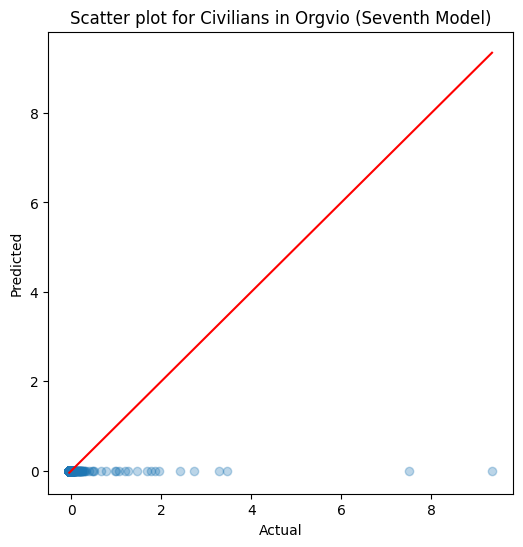

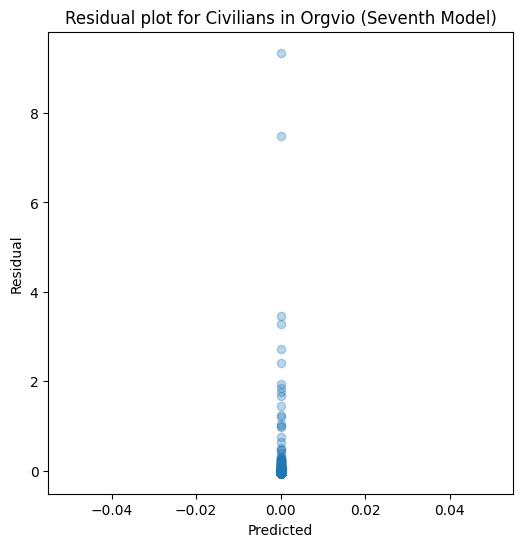

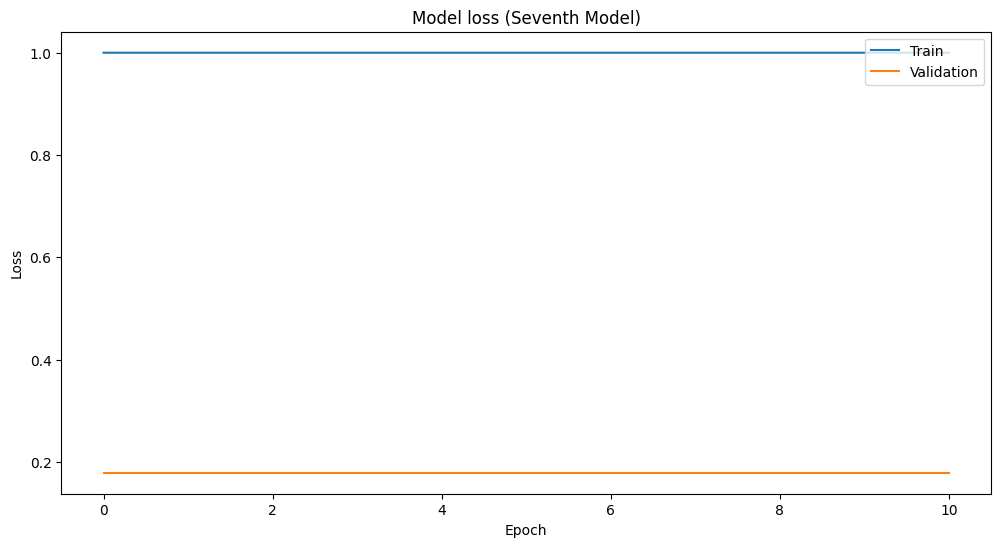

     Metrics  Training      Test
0       RMSE  1.000000  0.422928
1        MAE  0.079357  0.086504
2  R-Squared  0.000000 -0.000339
36/36 - 0s - 1ms/step - loss: 0.1789 - mean_absolute_error: 0.0865
Test mean absolute error (Seventh Model): 0.08650384098291397


In [40]:
################################################
# Seventh Model: Further modification
# -> Adjusting layer sizes and activation functions
# -> Adding dropout for regularization
################################################

# Define the cutoff year for training and testing for the seventh model
cutoff_year_7 = 2017  

train_df_7 = main_df[main_df['year_cy'] < cutoff_year_7]
test_df_7 = main_df[main_df['year_cy'] >= cutoff_year_7]

# Define features (X) and targets (y) for the seventh model
x_train_7 = train_df_7.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])
y_train_7 = train_df_7[['cumulative_total_deaths_in_orgvio_best_cy']]

x_test_7 = test_df_7.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])
y_test_7 = test_df_7[['cumulative_total_deaths_in_orgvio_best_cy']]


# Identify categorical and numeric columns for the seventh model
categorical_features_7 = ['country_cy', 'region_cy']
numeric_features_7 = [col for col in x_train_7.columns if col not in categorical_features_7]

# Modify the definition of the preprocessor for the seventh model to handle unknown categories
preprocessor_7 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_7),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_7)
    ])

# Fit and transform the training data for the seventh model
x_train_scaled_7 = preprocessor_7.fit_transform(x_train_7)
x_test_scaled_7 = preprocessor_7.transform(x_test_7)

# Scale the target variables for the seventh model
scaler_y_7 = StandardScaler()
y_train_scaled_7 = scaler_y_7.fit_transform(y_train_7)
y_test_scaled_7 = scaler_y_7.transform(y_test_7)

# Define the input dimension for the seventh model
input_dim_7 = x_train_scaled_7.shape[1]

# Define your seventh model
model_7 = Sequential()

# Add layers to the seventh model
model_7.add(Dense(108, activation='linear', input_shape=(input_dim_7,)))
model_7.add(Dense(54, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(6, activation='relu'))
model_7.add(Dense(1, activation='relu'))

# Compile the seventh model
model_7.compile(optimizer='adam', loss="mse", metrics=['mean_absolute_error'])

# Print the seventh model summary
model_7.summary()

# Define callbacks for the seventh model
early_stopping_7 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_7 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training the seventh model
history_7 = model_7.fit(
    x_train_scaled_7, y_train_scaled_7,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_scaled_7, y_test_scaled_7),
    callbacks=[early_stopping_7, reduce_lr_7]
)

# Evaluate the seventh model
loss_7, mae_7 = model_7.evaluate(x_test_scaled_7, y_test_scaled_7)
print(f"Mean Absolute Error on test data (Seventh Model): {mae_7}")

# Make predictions with the seventh model
y_pred_scaled_7 = model_7.predict(x_test_scaled_7)

# Inverse transform predictions for the seventh model
y_pred_7 = scaler_y_7.inverse_transform(y_pred_scaled_7)

# Calculate metrics for the seventh model
train_rmse_7 = np.sqrt(mean_squared_error(y_train_scaled_7, model_7.predict(x_train_scaled_7)))
train_mae_7 = mean_absolute_error(y_train_scaled_7, model_7.predict(x_train_scaled_7))
train_r2_7 = r2_score(y_train_scaled_7, model_7.predict(x_train_scaled_7))

# Calculate additional performance metrics for the seventh model
mse_7 = mean_squared_error(y_test_scaled_7, y_pred_scaled_7)
rmse_7 = np.sqrt(mse_7)
r2_7 = r2_score(y_test_scaled_7, y_pred_scaled_7)

print(f"Mean Squared Error (Seventh Model): {mse_7}")
print(f"Root Mean Squared Error (Seventh Model): {rmse_7}")
print(f"R-squared (Seventh Model): {r2_7}")

# Scatter plots: Actual vs Predicted values for the seventh model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_scaled_7, y_pred_scaled_7, alpha=0.3)
plt.plot([min(y_test_scaled_7), max(y_test_scaled_7)], [min(y_test_scaled_7), max(y_test_scaled_7)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for Civilians in Orgvio (Seventh Model)')
plt.show()

# Residual plot for the seventh model
residuals_7 = y_test_scaled_7 - y_pred_scaled_7
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_scaled_7, residuals_7, alpha=0.3)
plt.hlines(0, min(y_pred_scaled_7), max(y_pred_scaled_7), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for Civilians in Orgvio (Seventh Model)')
plt.show()

# Learning curves: Training and validation loss over epochs for the seventh model
plt.figure(figsize=(12, 6))
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model loss (Seventh Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate metrics for test set for the seventh model
test_rmse_7 = np.sqrt(mean_squared_error(y_test_scaled_7, y_pred_scaled_7))
test_mae_7 = mean_absolute_error(y_test_scaled_7, y_pred_scaled_7)
test_r2_7 = r2_score(y_test_scaled_7, y_pred_scaled_7)

# Create DataFrame for comparison for the seventh model
comparison_metrics_df_7 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_7, train_mae_7, train_r2_7],
    'Test': [test_rmse_7, test_mae_7, test_r2_7]
})

print(comparison_metrics_df_7)

# Evaluate the seventh model again
test_loss_7, test_mae_7 = model_7.evaluate(x_test_scaled_7, y_test_scaled_7, verbose=2)
print("Test mean absolute error (Seventh Model):", test_mae_7)


In [ ]:
################################################
# Eighth Model: Further modification
# -> Adjusting callbacks and regularization
################################################

# Define the cutoff year for training and testing for the eighth model
cutoff_year_8 = 2016

train_df_8 = main_df[main_df['year_cy'] < cutoff_year_8]
test_df_8 = main_df[main_df['year_cy'] >= cutoff_year_8]

# Define features (X) and targets (y) for the eighth model
x_train_8 = train_df_8.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])
y_train_8 = train_df_8[['cumulative_total_deaths_in_orgvio_best_cy']]

x_test_8 = test_df_8.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy',
    'cumulative_total_deaths_in_orgvio_best_cy',
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])
y_test_8 = test_df_8[['cumulative_total_deaths_in_orgvio_best_cy']]

# Identify categorical and numeric columns for the eighth model
categorical_features_8 = ['country_cy', 'region_cy']
numeric_features_8 = [col for col in x_train_8.columns if col not in categorical_features_8]

# Modify the definition of the preprocessor for the eighth model to handle unknown categories
preprocessor_8 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_8),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_8)
    ])

# Fit and transform the training data for the eighth model
x_train_scaled_8 = preprocessor_8.fit_transform(x_train_8)
x_test_scaled_8 = preprocessor_8.transform(x_test_8)

# Scale the target variables for the eighth model
scaler_y_8 = StandardScaler()
y_train_scaled_8 = scaler_y_8.fit_transform(y_train_8)
y_test_scaled_8 = scaler_y_8.transform(y_test_8)

# Define the input dimension for the eighth model
input_dim_8 = x_train_scaled_8.shape[1]


# Define a function to schedule the learning rate
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# Define your eighth model
model_8 = Sequential()

# Add layers to the eighth model
model_8.add(Dense(128, activation='linear', input_shape=(input_dim_8,)))
model_8.add(Dropout(0.3))  # Adding more dropout for regularization
model_8.add(Dense(64, activation='relu'))
model_8.add(Dropout(0.3))  # Adding more dropout for regularization
model_8.add(Dense(32, activation='linear'))
model_8.add(Dropout(0.3))  # Adding more dropout for regularization
model_8.add(Dense(16, activation='relu'))
model_8.add(Dense(8, activation='relu'))
model_8.add(Dense(1, activation='linear'))  # Adjusted to output single value

# Compile the eighth model
model_8.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mean_absolute_error'])

# Print the eighth model summary
model_8.summary()

# Define callbacks for the eighth model
early_stopping_8 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_8 = LearningRateScheduler(lr_scheduler)  # Using the custom learning rate scheduler


# Training the eighth model
history_8 = model_8.fit(
    x_train_scaled_8, y_train_scaled_8,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_scaled_8, y_test_scaled_8),
    callbacks=[early_stopping_8, reduce_lr_8]
)

# Evaluate the eighth model
loss_8, mae_8 = model_8.evaluate(x_test_scaled_8, y_test_scaled_8)
print(f"Mean Absolute Error on test data (Eighth Model): {mae_8}")

# Make predictions with the eighth model
y_pred_scaled_8 = model_8.predict(x_test_scaled_8)

# Inverse transform predictions for the eighth model
y_pred_8 = scaler_y_8.inverse_transform(y_pred_scaled_8)

# Calculate additional performance metrics for the eighth model
mse_8 = mean_squared_error(y_test_scaled_8, y_pred_scaled_8)
rmse_8 = np.sqrt(mse_8)
r2_8 = r2_score(y_test_scaled_8, y_pred_scaled_8)

print(f"Mean Squared Error (Eighth Model): {mse_8}")
print(f"Root Mean Squared Error (Eighth Model): {rmse_8}")
print(f"R-squared (Eighth Model): {r2_8}")

# Scatter plots: Actual vs Predicted values for the eighth model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_scaled_8, y_pred_scaled_8, alpha=0.3)
plt.plot([min(y_test_scaled_8), max(y_test_scaled_8)], [min(y_test_scaled_8), max(y_test_scaled_8)], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter plot for Civilians in Orgvio (Eighth Model)')
plt.show()

# Residual plot for the eighth model
residuals_8 = y_test_scaled_8 - y_pred_scaled_8
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_scaled_8, residuals_8, alpha=0.3)
plt.hlines(0, min(y_pred_scaled_8), max(y_pred_scaled_8), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for Civilians in Orgvio (Eighth Model)')
plt.show()

# Learning curves: Training and validation loss over epochs for the eighth model
plt.figure(figsize=(12, 6))
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'])
plt.title('Model loss (Eighth Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Calculate metrics for the eighth model
train_rmse_8 = np.sqrt(mean_squared_error(y_train_scaled_8, model_8.predict(x_train_scaled_8)))
train_mae_8 = mean_absolute_error(y_train_scaled_8, model_8.predict(x_train_scaled_8))
train_r2_8 = r2_score(y_train_scaled_8, model_8.predict(x_train_scaled_8))

# Calculate metrics for test set for the eighth model
test_rmse_8 = np.sqrt(mean_squared_error(y_test_scaled_8, y_pred_scaled_8))
test_mae_8 = mean_absolute_error(y_test_scaled_8, y_pred_scaled_8)
test_r2_8 = r2_score(y_test_scaled_8, y_pred_scaled_8)

# Create DataFrame for comparison for the eighth model
comparison_metrics_df_8 = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R-Squared'],
    'Training': [train_rmse_8, train_mae_8, train_r2_8],
    'Test': [test_rmse_8, test_mae_8, test_r2_8]
})

print(comparison_metrics_df_8)

# Evaluate the eighth model again
test_loss_8, test_mae_8 = model_8.evaluate(x_test_scaled_8, y_test_scaled_8, verbose=2)
print("Test mean absolute error (Eighth Model):", test_mae_8)

In [ ]:
#####################################
# Regression model
#####################################

# Preparation
main_regr_df = main_df.drop(columns=['cumulative_total_deaths_parties_in_orgvio_cy', 
                                'cumulative_total_deaths_civilians_in_orgvio_cy'])




In [ ]:

# Define the year to split the data
split_year = 2022  # Example split year, adjust based on your data

# Split the data into training and testing sets based on the year
regr_train_df = main_regr_df[main_regr_df['year_cy'] < split_year]
regr_test_df = main_regr_df[main_regr_df['year_cy'] >= split_year]

# Separate features and target variable for training data
regr_X_train = regr_train_df.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy', "country_cy","region_cy"])
regr_y_train = regr_train_df['cumulative_total_deaths_in_orgvio_best_cy']

# Separate features and target variable for testing data
regr_X_test = regr_test_df.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy', "country_cy","region_cy"])
regr_y_test = regr_test_df['cumulative_total_deaths_in_orgvio_best_cy']

# Align the train and test sets to ensure they have the same columns after encoding
regr_X_train, regr_X_test = regr_X_train.align(regr_X_test, join='left', axis=1, fill_value=0)

# Initialize the regression model
regr_model = LinearRegression()

# Train the model
regr_model.fit(regr_X_train, regr_y_train)

# Make predictions on test set
regr_y_pred_test = regr_model.predict(regr_X_test)

# Make predictions on train set
regr_y_pred_train = regr_model.predict(regr_X_train)

# Evaluate the model on test data
regr_mae_test = mean_absolute_error(regr_y_test, regr_y_pred_test)
regr_mse_test = mean_squared_error(regr_y_test, regr_y_pred_test)
regr_rmse_test = regr_mse_test ** 0.5
regr_r2_test = r2_score(regr_y_test, regr_y_pred_test)

# Evaluate the model on train data
regr_mae_train = mean_absolute_error(regr_y_train, regr_y_pred_train)
regr_mse_train = mean_squared_error(regr_y_train, regr_y_pred_train)
regr_rmse_train = regr_mse_train ** 0.5
regr_r2_train = r2_score(regr_y_train, regr_y_pred_train)

# Print the metrics
print("Test set metrics:")
print(f'Mean Absolute Error: {regr_mae_test}')
print(f'Mean Squared Error: {regr_mse_test}')
print(f'Root Mean Squared Error: {regr_rmse_test}')
print(f'R-squared: {regr_r2_test}')

print("\nTrain set metrics:")
print(f'Mean Absolute Error: {regr_mae_train}')
print(f'Mean Squared Error: {regr_mse_train}')
print(f'Root Mean Squared Error: {regr_rmse_train}')
print(f'R-squared: {regr_r2_train}')

# Plot predicted vs actual values for test data
plt.figure(figsize=(10, 6))
plt.scatter(regr_y_test, regr_y_pred_test, alpha=0.5, label='Test Data')
plt.plot([min(regr_y_test), max(regr_y_test)], [min(regr_y_test), max(regr_y_test)], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

# Plot predicted vs actual values for train data
plt.figure(figsize=(10, 6))
plt.scatter(regr_y_train, regr_y_pred_train, alpha=0.5, label='Train Data')
plt.plot([min(regr_y_train), max(regr_y_train)], [min(regr_y_train), max(regr_y_train)], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()

In [ ]:
#####################################
# Regression model, only those where sth happened
#####################################

# Preparation
main_subset_regr_df = subset_main_df.drop(columns=['cumulative_total_deaths_parties_in_orgvio_cy', 
                                'cumulative_total_deaths_civilians_in_orgvio_cy'])



# Define the year to split the data
split_year = 2022  # Example split year, adjust based on your data

# Split the data into training and testing sets based on the year
regr_train_df = main_subset_regr_df[main_subset_regr_df['year_cy'] < split_year]
regr_test_df = main_subset_regr_df[main_subset_regr_df['year_cy'] >= split_year]

# Separate features and target variable for training data
regr_X_train = regr_train_df.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy', 'country_cy', 'region_cy'])
regr_y_train = regr_train_df['cumulative_total_deaths_in_orgvio_best_cy']

# Separate features and target variable for testing data
regr_X_test = regr_test_df.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy', 'country_cy', 'region_cy'])
regr_y_test = regr_test_df['cumulative_total_deaths_in_orgvio_best_cy']

# Align the train and test sets to ensure they have the same columns after encoding
regr_X_train, regr_X_test = regr_X_train.align(regr_X_test, join='left', axis=1, fill_value=0)

# Initialize the regression model
regr_model = LinearRegression()

# Train the model
regr_model.fit(regr_X_train, regr_y_train)

# Make predictions on the test set
regr_y_pred_test = regr_model.predict(regr_X_test)

# Make predictions on the train set
regr_y_pred_train = regr_model.predict(regr_X_train)

# Evaluate the model on the test data
regr_mae_test = mean_absolute_error(regr_y_test, regr_y_pred_test)
regr_mse_test = mean_squared_error(regr_y_test, regr_y_pred_test)
regr_rmse_test = regr_mse_test ** 0.5
regr_r2_test = r2_score(regr_y_test, regr_y_pred_test)

# Evaluate the model on the train data
regr_mae_train = mean_absolute_error(regr_y_train, regr_y_pred_train)
regr_mse_train = mean_squared_error(regr_y_train, regr_y_pred_train)
regr_rmse_train = regr_mse_train ** 0.5
regr_r2_train = r2_score(regr_y_train, regr_y_pred_train)

# Print the metrics
print("Test set metrics:")
print(f'Mean Absolute Error: {regr_mae_test}')
print(f'Mean Squared Error: {regr_mse_test}')
print(f'Root Mean Squared Error: {regr_rmse_test}')
print(f'R-squared: {regr_r2_test}')

print("\nTrain set metrics:")
print(f'Mean Absolute Error: {regr_mae_train}')
print(f'Mean Squared Error: {regr_mse_train}')
print(f'Root Mean Squared Error: {regr_rmse_train}')
print(f'R-squared: {regr_r2_train}')

# Plot predicted vs actual values for the test data
plt.figure(figsize=(10, 6))
plt.scatter(regr_y_test, regr_y_pred_test, alpha=0.5, label='Test Data')
plt.plot([min(regr_y_test), max(regr_y_test)], [min(regr_y_test), max(regr_y_test)], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

# Plot predicted vs actual values for the train data
plt.figure(figsize=(10, 6))
plt.scatter(regr_y_train, regr_y_pred_train, alpha=0.5, label='Train Data')
plt.plot([min(regr_y_train), max(regr_y_train)], [min(regr_y_train), max(regr_y_train)], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()

In [ ]:
# Define the year to split the data
regr_split_year_3 = 2017  # Example split year, adjust based on your data

# Split the data into training and testing sets based on the year
regr_train_df = main_regr_df[main_regr_df['year_cy'] < split_year]
regr_test_df = main_regr_df[main_regr_df['year_cy'] >= split_year]

# Preprocess the data by dropping specified columns
main_regr_df_3 = main_df.drop(columns=[
    'cumulative_total_deaths_parties_in_orgvio_cy', 
    'cumulative_total_deaths_civilians_in_orgvio_cy'
])

# Define the year to split the data
regr_split_year_3 = 2022  # Example split year, adjust based on your data

# Split the data into training and testing sets based on the year
regr_train_df_3 = main_regr_df[main_regr_df['year_cy'] < regr_split_year_3]
regr_test_df_3 = main_regr_df[main_regr_df['year_cy'] >= regr_split_year_3]

# Separate features and target variable for training data
regr_X_train_3 = regr_train_df_3.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy', 'country_cy', 'region_cy'])
regr_y_train_3 = regr_train_df_3['cumulative_total_deaths_in_orgvio_best_cy']

# Separate features and target variable for testing data
regr_X_test_3 = regr_test_df_3.drop(columns=['cumulative_total_deaths_in_orgvio_best_cy', 'country_cy', 'region_cy'])
regr_y_test_3 = regr_test_df_3['cumulative_total_deaths_in_orgvio_best_cy']

# Apply log transformation to the target variable
regr_y_train_log_3 = np.log1p(regr_y_train_3)  # log1p is used to handle zero or negative values
regr_y_test_log_3 = np.log1p(regr_y_test_3)

# Align the train and test sets to ensure they have the same columns after encoding
regr_X_train_3, regr_X_test_3 = regr_X_train_3.align(regr_X_test_3, join='left', axis=1, fill_value=0)

# Initialize the regression model
regr_model_3 = LinearRegression()

# Train the model on the transformed target
regr_model_3.fit(regr_X_train_3, regr_y_train_log_3)

# Make predictions on the test set
regr_y_pred_test_log_3 = regr_model_3.predict(regr_X_test_3)
regr_y_pred_train_log_3 = regr_model_3.predict(regr_X_train_3)

# Convert predictions back to the original scale
regr_y_pred_test_3 = np.expm1(regr_y_pred_test_log_3)  # expm1 to reverse log1p transformation
regr_y_pred_train_3 = np.expm1(regr_y_pred_train_log_3)

# Evaluate the model on the test data
regr_mae_test_3 = mean_absolute_error(regr_y_test_3, regr_y_pred_test_3)
regr_mse_test_3 = mean_squared_error(regr_y_test_3, regr_y_pred_test_3)
regr_rmse_test_3 = regr_mse_test_3 ** 0.5
regr_r2_test_3 = r2_score(regr_y_test_3, regr_y_pred_test_3)

# Evaluate the model on the train data
regr_mae_train_3 = mean_absolute_error(regr_y_train_3, regr_y_pred_train_3)
regr_mse_train_3 = mean_squared_error(regr_y_train_3, regr_y_pred_train_3)
regr_rmse_train_3 = regr_mse_train_3 ** 0.5
regr_r2_train_3 = r2_score(regr_y_train_3, regr_y_pred_train_3)

# Print the metrics
print("Test set metrics:")
print(f'Mean Absolute Error: {regr_mae_test_3}')
print(f'Mean Squared Error: {regr_mse_test_3}')
print(f'Root Mean Squared Error: {regr_rmse_test_3}')
print(f'R-squared: {regr_r2_test_3}')

print("\nTrain set metrics:")
print(f'Mean Absolute Error: {regr_mae_train_3}')
print(f'Mean Squared Error: {regr_mse_train_3}')
print(f'Root Mean Squared Error: {regr_rmse_train_3}')
print(f'R-squared: {regr_r2_train_3}')

# Plot predicted vs actual values for the test data
plt.figure(figsize=(10, 6))
plt.scatter(regr_y_test_3, regr_y_pred_test_3, alpha=0.5, label='Test Data')
plt.plot([min(regr_y_test_3), max(regr_y_test_3)], [min(regr_y_test_3), max(regr_y_test_3)], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

# Plot predicted vs actual values for the train data
plt.figure(figsize=(10, 6))
plt.scatter(regr_y_train_3, regr_y_pred_train_3, alpha=0.5, label='Train Data')
plt.plot([min(regr_y_train_3), max(regr_y_train_3)], [min(regr_y_train_3), max(regr_y_train_3)], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()